# Imports

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)#set  random seed for reproducability
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from keras.models import Sequential
from keras.layers import Dense

# Load Data and Merge

In [30]:
arrest_data = pd.read_csv("arrests_w_census_loc.csv")
arrest_data.PERP_RACE[arrest_data.PERP_RACE.str.contains("WHITE")]=0
arrest_data.PERP_RACE[arrest_data.PERP_RACE != 0]=1
arrest_data = arrest_data.groupby(["PERP_RACE","BlockLocation"]).size().reset_index(name='counts')
blockLocation = arrest_data["BlockLocation"]
blockLat = [float(re.findall(r'[-\d\.]+', bl)[0]) for bl in blockLocation]
blockLon = [float(re.findall(r'[-\d\.]+', bl)[1]) for bl in blockLocation]
arrest_data["blockLat"]=blockLat
arrest_data["blockLon"]=blockLon
arrest_data = arrest_data.drop("BlockLocation", axis=1)
arrest_data = arrest_data.rename(columns={"counts": "Num_Arrests", "PERP_RACE": "Race"})
block_data = pd.read_csv("census_block_loc.csv")
block_data = pd.merge(left=arrest_data, right=block_data,
                      left_on=["blockLat","blockLon"], right_on=["Latitude","Longitude"])
census_data = pd.read_csv("nyc_census_tracts.csv")
tracts = block_data["BlockCode"]
tracts = [int(str(tract)[:-4]) for tract in tracts]
block_data["tracts"]=tracts
block_data = block_data.drop(columns=["Latitude","Longitude","BlockCode","County","blockLat","blockLon"])
data = pd.merge(left=block_data, right=census_data, left_on="tracts", right_on="CensusTract")
data = data.drop("tracts", axis=1)
data = data.drop("State", axis=1)
data

C:\Users\TestAccount\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\TestAccount\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Race,Num_Arrests,CensusTract,County,Borough,TotalPop,Men,Women,Hispanic,White,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,0,1,36085024402,Richmond,Staten Island,4241,2023,2218,3.7,84.5,...,1.1,0.6,4.0,44.3,2046,75.2,21.2,3.6,0.0,8.3
1,0,4,36085024402,Richmond,Staten Island,4241,2023,2218,3.7,84.5,...,1.1,0.6,4.0,44.3,2046,75.2,21.2,3.6,0.0,8.3
2,0,1,36085024402,Richmond,Staten Island,4241,2023,2218,3.7,84.5,...,1.1,0.6,4.0,44.3,2046,75.2,21.2,3.6,0.0,8.3
3,0,1,36085024402,Richmond,Staten Island,4241,2023,2218,3.7,84.5,...,1.1,0.6,4.0,44.3,2046,75.2,21.2,3.6,0.0,8.3
4,0,1,36085024402,Richmond,Staten Island,4241,2023,2218,3.7,84.5,...,1.1,0.6,4.0,44.3,2046,75.2,21.2,3.6,0.0,8.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11336,1,2,36005044800,Bronx,Bronx,2181,1092,1089,9.9,1.6,...,2.8,0.0,0.0,49.0,1233,77.9,19.6,2.5,0.0,10.7
11337,1,2,36005044800,Bronx,Bronx,2181,1092,1089,9.9,1.6,...,2.8,0.0,0.0,49.0,1233,77.9,19.6,2.5,0.0,10.7
11338,1,2,36005044800,Bronx,Bronx,2181,1092,1089,9.9,1.6,...,2.8,0.0,0.0,49.0,1233,77.9,19.6,2.5,0.0,10.7
11339,1,5,36005043000,Bronx,Bronx,3321,1380,1941,16.2,2.2,...,5.5,0.0,0.0,38.2,1466,76.2,22.4,1.4,0.0,9.5


# Remove Outlier Locations

There are 11341 Samples Before Outlier Removal


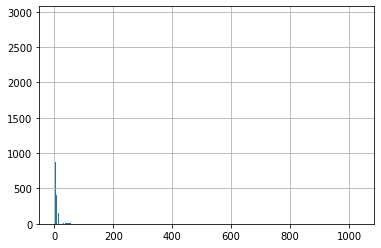

There are 11021 Samples After Outlier Removal


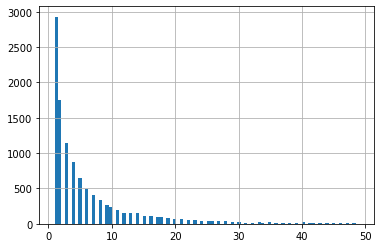

97.1783793316286% of Samples were Kept


In [31]:
data["Num_Arrests"].hist(bins='auto')
data_size=data.shape[0]
print("There are",data_size,"Samples Before Outlier Removal")
plt.show()
data = data[data["Num_Arrests"]<50]
new_size=data.shape[0]
print("There are",new_size,"Samples After Outlier Removal")
data["Num_Arrests"].hist(bins='auto')
plt.show()
print(100*new_size/data_size,"% of Samples were Kept",sep="")

# Create Data Aggregates by County

In [32]:
def agg_all(data):
    new_data = {}
    for colname in ['Num_Arrests','TotalPop','Men','Women','Citizen','Income','IncomeErr', 'Employed']:
        new_data[colname]=data[colname].sum()
    for colname in ['Hispanic', 'White', 'Black', 'Native', 'Asian','IncomePerCap','IncomePerCapErr','Poverty', 'ChildPoverty', 'Professional', 'Service', 'Office',
            'Construction', 'Production', 'Drive', 'Carpool', 'Transit', 'Walk','OtherTransp', 'WorkAtHome',
           'MeanCommute','PrivateWork','PublicWork','SelfEmployed','FamilyWork','Unemployment']:
        ratio = data[colname]*data['TotalPop']
        new_data[colname]=(ratio.sum()/100)/data.size
    return pd.Series(new_data)

agg_data = data.groupby(['County','Race']).apply(agg_all)

# Attatch Aggregate to Data

In [33]:
agg_data["arrest_ratio"]=agg_data["Num_Arrests"]/agg_data["TotalPop"]
arrest_ratio = list(agg_data["arrest_ratio"])
county = list(agg_data.index.get_level_values(0))
race = list(agg_data.index.get_level_values(1))
agg_data = pd.DataFrame(arrest_ratio, columns=["arrest_ratio"])
agg_data["County"]=county
agg_data["Race"]=race
data = pd.merge(data, agg_data, on=["County","Race"])
data["County_Num_Arrests"]=data["arrest_ratio"]*data["TotalPop"]
data = data.drop("arrest_ratio", axis=1)
display(data.head())

,Race,Num_Arrests,CensusTract,County,Borough,TotalPop,Men,Women,Hispanic,White,...,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,County_Num_Arrests
0,0,1,36085024402,Richmond,Staten Island,4241,2023,2218,3.7,84.5,...,0.6,4.0,44.3,2046,75.2,21.2,3.6,0.0,8.3,2.238152
1,0,4,36085024402,Richmond,Staten Island,4241,2023,2218,3.7,84.5,...,0.6,4.0,44.3,2046,75.2,21.2,3.6,0.0,8.3,2.238152
2,0,1,36085024402,Richmond,Staten Island,4241,2023,2218,3.7,84.5,...,0.6,4.0,44.3,2046,75.2,21.2,3.6,0.0,8.3,2.238152
3,0,1,36085024402,Richmond,Staten Island,4241,2023,2218,3.7,84.5,...,0.6,4.0,44.3,2046,75.2,21.2,3.6,0.0,8.3,2.238152
4,0,1,36085024402,Richmond,Staten Island,4241,2023,2218,3.7,84.5,...,0.6,4.0,44.3,2046,75.2,21.2,3.6,0.0,8.3,2.238152


# Apply Z Scaling to Continuous Features

In [34]:
num_cols = ['TotalPop','Men','Women','Hispanic','White','Black','Native','Asian','Citizen','Income','IncomeErr','IncomePerCap','IncomePerCapErr','Poverty','ChildPoverty','Professional','Service','Office','Construction','Production','Drive','Carpool','Transit','Walk','OtherTransp','WorkAtHome','MeanCommute','Employed','PrivateWork','PublicWork','SelfEmployed','FamilyWork','Unemployment']
X = data[num_cols].values
data.drop(columns=num_cols)
scaler = StandardScaler()
X = scaler.fit_transform(X)
num_data = pd.DataFrame(X, columns=num_cols)
data[num_cols]=num_data
data = data.dropna()

# Split Data by Race and Into Train/Test Datasets

In [35]:
cols = data.shape[1]
data_white = data[data["Race"]==0].drop("Race", axis=1)
data_non_white=data[data["Race"]==1].drop("Race", axis=1)
data_white_train = data_white.sample(frac=0.8,random_state=101)
data_white_test  = data_white.drop(data_white_train.index)
data_non_white_train = data_non_white.sample(frac=0.8,random_state=101)
data_non_white_test  = data_non_white.drop(data_non_white_train.index)
Xw = data_white_train.iloc[:,1:cols]
yw = data_white_train.iloc[:,0]
Xnw = data_non_white_train.iloc[:,1:cols]
ynw = data_non_white_train.iloc[:,0]
Xwt = data_white_test.iloc[:,1:cols]
ywt = data_white_test.iloc[:,0]
Xnwt = data_non_white_test.iloc[:,1:cols]
ynwt = data_non_white_test.iloc[:,0]

# Encode Categorical Features as Numerical Values

In [36]:
cat_cols = ['CensusTract','County','Borough']
encoder = LabelEncoder()
for var in cat_cols:
    Xw[var] = encoder.fit_transform(Xw[var])
    Xnw[var] = encoder.fit_transform(Xnw[var])
    Xwt[var] = encoder.fit_transform(Xwt[var])
    Xnwt[var] = encoder.fit_transform(Xnwt[var])

# Initial Test of Nonlinear Kernels

In [9]:
rbfw = SVR(gamma='scale',kernel='rbf')
cv = cross_val_score(rbfw, Xw, yw, cv=50, scoring="neg_mean_squared_error")
print("The average MSE for White RBF is",-sum(cv)/len(cv))

rbfnw = SVR(gamma='scale',kernel='rbf')
cv = cross_val_score(rbfnw, Xnw, ynw, cv=50, scoring="neg_mean_squared_error")
print("The average MSE for Non-White RBF is",-sum(cv)/len(cv))

polyw = SVR(gamma='scale',kernel='poly')
cv = cross_val_score(polyw, Xw, yw, cv=50, scoring="neg_mean_squared_error")
print("The average MSE for White Polynomial is",-sum(cv)/len(cv))

polynw = SVR(gamma='scale',kernel='poly')
cv = cross_val_score(polynw, Xnw, ynw, cv=50, scoring="neg_mean_squared_error")
print("The average MSE for Non-White Polynomial is",-sum(cv)/len(cv))

The average MSE for White RBF is 43.60113734897231
The average MSE for Non-White RBF is 78.38231561170497
The average MSE for White Polynomial is 43.69241122108813
The average MSE for Non-White Polynomial is 77.81561534226094


# Random Search to Tune Hyperparameters

In [10]:
params = {"C":[0.1,0.5,1,5,10,50,100,500,1000],"epsilon":uniform(1,3),"kernel":["poly","rbf"]}

rscv = RandomizedSearchCV(SVR(gamma="scale"),params,cv=50,iid=False)
rscv.fit(Xw,yw)
print("optimal white C", rscv.best_estimator_.get_params()["C"])
print("optimal white epsilon", rscv.best_estimator_.get_params()["epsilon"])
print("optimal white kernel", rscv.best_estimator_.get_params()["kernel"])

rscv2 = RandomizedSearchCV(SVR(gamma="scale"),params,cv=50,iid=False)
rscv2.fit(Xnw,ynw)
print("optimal non-white C", rscv2.best_estimator_.get_params()["C"])
print("optimal non-white epsilon", rscv2.best_estimator_.get_params()["epsilon"])
print("optimal non-white kernel", rscv2.best_estimator_.get_params()["kernel"])


optimal white C 1000
optimal white epsilon 1.3164827794908118
optimal white kernel rbf
optimal non-white C 500
optimal non-white epsilon 3.6013498216291664
optimal non-white kernel rbf


# Run Test Data

In [11]:
Final_model = SVR(kernel='rbf', C=750, gamma="scale", epsilon=1.5)
Final_model.fit(Xw, yw)
test_predicted = Final_model.predict(Xwt)
mse = mean_squared_error(ywt, test_predicted)
print("Test MSE for White: ",mse)
mae = mean_absolute_error(ywt, test_predicted)
print("Test MAE for White: ",mae)
Final_model.fit(Xnw, ynw)
test_predicted_2 = Final_model.predict(Xnwt)
mse = mean_squared_error(ynwt, test_predicted_2)
print("Test MSE for Non-White: ",mse)
mae = mean_absolute_error(ynwt, test_predicted_2)
print("Test MAE for Non-White: ",mae)

Test MSE for White:  35.89589831157217
Test MAE for White:  3.304671823027504
Test MSE for Non-White:  79.8645841908493
Test MAE for Non-White:  5.269566890760708


# Try Random Forrest

In [12]:
model = RandomForestRegressor()
model.fit(Xw, yw)
cv = cross_val_score(model, Xw, yw, cv=50, scoring="neg_mean_squared_error")
print("The average MSE for White is",-sum(cv)/len(cv))
model.fit(Xnw, ynw)
cv = cross_val_score(model, Xnw, ynw, cv=50, scoring="neg_mean_squared_error")
print("The average MSE for Non-White is",-sum(cv)/len(cv))

C:\Users\TestAccount\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The average MSE for White is 36.92104817231116
The average MSE for Non-White is 58.8028045980814


# Tune Random Forrest Hyperparameters

In [13]:
params = {"min_samples_split":[2,5,10,15,20,25,30,35], "max_features":[5,10,15,20,25,30]}

rscv = RandomizedSearchCV(RandomForestRegressor(n_estimators=500),params,cv=50,iid=False)
rscv.fit(Xw,yw)
print("optimal white min_samples_split", rscv.best_estimator_.get_params()["min_samples_split"])
print("optimal white max_features", rscv.best_estimator_.get_params()["max_features"])

rscv2 = RandomizedSearchCV(RandomForestRegressor(n_estimators=500),params,cv=50,iid=False)
rscv2.fit(Xnw,ynw)
print("optimal non-white min_samples_split", rscv2.best_estimator_.get_params()["min_samples_split"])
print("optimal non-white max_features", rscv2.best_estimator_.get_params()["max_features"])

optimal white min_samples_split 35
optimal white max_features 30
optimal non-white min_samples_split 30
optimal non-white max_features 15


# Predict Test Data From Best Model

In [37]:
Final_model = RandomForestRegressor(n_estimators=500, min_samples_split=32, max_features=25)
Final_model.fit(Xw, yw)
test_predicted = Final_model.predict(Xwt)
mse = mean_squared_error(ywt, test_predicted)
print("Test MSE for White: ",mse)
mae = mean_absolute_error(ywt, test_predicted)
print("Test MAE for White: ",mae)
Final_model.fit(Xnw, ynw)
test_predicted_2 = Final_model.predict(Xnwt)
mse = mean_squared_error(ynwt, test_predicted_2)
print("Test MSE for Non-White: ",mse)
mae = mean_absolute_error(ynwt, test_predicted_2)
print("Test MAE for Non-White: ",mae)

Test MSE for White:  30.854126973866332
Test MAE for White:  3.443983715149438
Test MSE for Non-White:  53.469200182592445
Test MAE for Non-White:  4.74925570008868


# Create Bias Metric By County and Block

In [38]:
Final_model.fit(Xw, yw)
Xw["predicted_w"] = Final_model.predict(Xw)
Final_model.fit(Xnw, ynw)
Xnw["predicted_nw"] = Final_model.predict(Xnw)
Xnw = Xnw[["CensusTract", "predicted_nw","County_Num_Arrests"]]
Xnw = Xnw.rename(columns={"County_Num_Arrests":"County_Num_Arrests_nw"})
X = pd.merge(left=Xw, right=Xnw,left_on="CensusTract", right_on="CensusTract")
X["Non-White"]=1-X["White"]
X["y"] = np.log(abs(X["predicted_w"]/X["White"]-X["predicted_nw"]/X["Non-White"]))
X = X.replace(np.inf, np.nan)
X = X.dropna()
X_train = X.sample(frac=0.8,random_state=101)
Xt=X.drop(X_train.index)
X=X_train
y = X["y"]
yt=Xt["y"]
X = X.drop(columns=['Hispanic','Black','Native','Asian',"y"])
Xt = Xt.drop(columns=['Hispanic','Black','Native','Asian',"y"])
yc = np.log(abs(X["County_Num_Arrests"]/X["White"]-X["County_Num_Arrests_nw"]/X["Non-White"]))

# Split Data into Training and Validation

In [39]:
X['yb']=y
X['yc']=yc
Xtrain = X.sample(frac=0.9,random_state=101)
Xvalid = X.drop(Xtrain.index)
ybtrain = Xtrain['yb']
yctrain = Xtrain['yc']
ybvalid = Xvalid['yb']
ycvalid = Xvalid['yc']
X = X.drop(columns=['yb','yc'])

# Create Plot of MSE vs Smoothing Factor 

Epoch 1/500
7636/7636 [==============================] - 1s 80us/step - loss: 3.5774
Epoch 2/500
7636/7636 [==============================] - 0s 51us/step - loss: 0.2051
Epoch 3/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.1047
Epoch 4/500
7636/7636 [==============================] - 0s 51us/step - loss: 0.0713
Epoch 5/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.1191
Epoch 6/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.1634
Epoch 7/500
7636/7636 [==============================] - 0s 52us/step - loss: 0.5463
Epoch 8/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0110
Epoch 9/500
7636/7636 [==============================] - 0s 48us/step - loss: 0.9331
Epoch 10/500
7636/7636 [==============================] - 0s 51us/step - loss: 0.0044
Epoch 11/500
7636/7636 [==============================] - 0s 48us/step - loss: 0.1407
Epoch 12/500
7636/7636 [==============================] - 0s 50

7636/7636 [==============================] - 0s 50us/step - loss: 0.0623
Epoch 96/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.1167
Epoch 97/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0410
Epoch 98/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.1766
Epoch 99/500
7636/7636 [==============================] - 0s 48us/step - loss: 0.1644
Epoch 100/500
7636/7636 [==============================] - 0s 48us/step - loss: 0.0213
Epoch 101/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.1062
Epoch 102/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.1692
Epoch 103/500
7636/7636 [==============================] - 0s 48us/step - loss: 0.0454
Epoch 104/500
7636/7636 [==============================] - 0s 48us/step - loss: 0.1510
Epoch 105/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0359
Epoch 106/500
7636/7636 [==============================] - 0s

7636/7636 [==============================] - 0s 49us/step - loss: 0.1115
Epoch 189/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.1143
Epoch 190/500
7636/7636 [==============================] - 0s 48us/step - loss: 0.2267
Epoch 191/500
7636/7636 [==============================] - 0s 49us/step - loss: 6.7387e-05
Epoch 192/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0566
Epoch 193/500
7636/7636 [==============================] - 0s 47us/step - loss: 0.3965
Epoch 194/500
7636/7636 [==============================] - 0s 47us/step - loss: 1.4942e-04
Epoch 195/500
7636/7636 [==============================] - 0s 50us/step - loss: 3.1244e-04
Epoch 196/500
7636/7636 [==============================] - 0s 47us/step - loss: 0.3365
Epoch 197/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.0606e-04
Epoch 198/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0041
Epoch 199/500
7636/7636 [================

7636/7636 [==============================] - 0s 47us/step - loss: 0.0059
Epoch 282/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.2611
Epoch 283/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.5840e-04
Epoch 284/500
7636/7636 [==============================] - 0s 47us/step - loss: 0.1617
Epoch 285/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.0025
Epoch 286/500
7636/7636 [==============================] - 0s 48us/step - loss: 0.0045
Epoch 287/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0574
Epoch 288/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0414
Epoch 289/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.1501
Epoch 290/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.1839e-04
Epoch 291/500
7636/7636 [==============================] - 0s 48us/step - loss: 0.1602
Epoch 292/500
7636/7636 [========================

Epoch 374/500
7636/7636 [==============================] - 0s 48us/step - loss: 0.0038
Epoch 375/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.0655
Epoch 376/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.0117
Epoch 377/500
7636/7636 [==============================] - 0s 51us/step - loss: 0.1297
Epoch 378/500
7636/7636 [==============================] - 0s 47us/step - loss: 0.0085
Epoch 379/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.1761
Epoch 380/500
7636/7636 [==============================] - 0s 49us/step - loss: 7.7982e-05
Epoch 381/500
7636/7636 [==============================] - 0s 51us/step - loss: 0.0036
Epoch 382/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0728
Epoch 383/500
7636/7636 [==============================] - 0s 51us/step - loss: 0.1212
Epoch 384/500
7636/7636 [==============================] - 0s 48us/step - loss: 1.7316e-04
Epoch 385/500
7636/7636 [==========

7636/7636 [==============================] - 0s 50us/step - loss: 6.7842e-05
Epoch 468/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.0980
Epoch 469/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.0013
Epoch 470/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0595
Epoch 471/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0014
Epoch 472/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.2382
Epoch 473/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.6048e-04
Epoch 474/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.4072e-04
Epoch 475/500
7636/7636 [==============================] - 0s 48us/step - loss: 7.5551e-04
Epoch 476/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0678
Epoch 477/500
7636/7636 [==============================] - 0s 52us/step - loss: 0.2402
Epoch 478/500
7636/7636 [================

7636/7636 [==============================] - 0s 52us/step - loss: 0.0109
Epoch 60/500
7636/7636 [==============================] - 0s 54us/step - loss: 0.0845
Epoch 61/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.2017e-04
Epoch 62/500
7636/7636 [==============================] - 0s 51us/step - loss: 0.0231
Epoch 63/500
7636/7636 [==============================] - 0s 51us/step - loss: 0.0073
Epoch 64/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.0850
Epoch 65/500
7636/7636 [==============================] - 0s 51us/step - loss: 2.9711e-04
Epoch 66/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.0105
Epoch 67/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0414
Epoch 68/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0056
Epoch 69/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.0249
Epoch 70/500
7636/7636 [==============================] - 0

7636/7636 [==============================] - 0s 51us/step - loss: 0.0030
Epoch 153/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.1998
Epoch 154/500
7636/7636 [==============================] - 0s 49us/step - loss: 6.8772e-05
Epoch 155/500
7636/7636 [==============================] - 0s 51us/step - loss: 5.8175e-05
Epoch 156/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.0546e-04
Epoch 157/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.0204
Epoch 158/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0248
Epoch 159/500
7636/7636 [==============================] - 0s 48us/step - loss: 0.0125
Epoch 160/500
7636/7636 [==============================] - 0s 51us/step - loss: 0.0045
Epoch 161/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0415
Epoch 162/500
7636/7636 [==============================] - 0s 50us/step - loss: 3.7325e-04
Epoch 163/500
7636/7636 [================

7636/7636 [==============================] - 0s 49us/step - loss: 0.0550
Epoch 245/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.6650e-04
Epoch 246/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.1220e-04
Epoch 247/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.0342
Epoch 248/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.1957e-04
Epoch 249/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0455
Epoch 250/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.0395e-04
Epoch 251/500
7636/7636 [==============================] - 0s 50us/step - loss: 4.0963e-04
Epoch 252/500
7636/7636 [==============================] - 0s 51us/step - loss: 0.0181
Epoch 253/500
7636/7636 [==============================] - 0s 48us/step - loss: 0.0391
Epoch 254/500
7636/7636 [==============================] - 0s 51us/step - loss: 0.0019
Epoch 255/500
7636/7636 [============

7636/7636 [==============================] - 0s 49us/step - loss: 9.3534e-04
Epoch 338/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.0063
Epoch 339/500
7636/7636 [==============================] - 0s 51us/step - loss: 0.0097
Epoch 340/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.0142
Epoch 341/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.0082
Epoch 342/500
7636/7636 [==============================] - 0s 51us/step - loss: 0.0062
Epoch 343/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.0316
Epoch 344/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.2451e-04
Epoch 345/500
7636/7636 [==============================] - 0s 51us/step - loss: 0.0027
Epoch 346/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0454
Epoch 347/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.9262e-04
Epoch 348/500
7636/7636 [====================

7636/7636 [==============================] - 0s 49us/step - loss: 1.2325e-04
Epoch 430/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0290
Epoch 431/500
7636/7636 [==============================] - 0s 50us/step - loss: 9.6664e-05
Epoch 432/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.0030
Epoch 433/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.0187
Epoch 434/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0122
Epoch 435/500
7636/7636 [==============================] - 0s 51us/step - loss: 9.8677e-04
Epoch 436/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.0327
Epoch 437/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.8127e-04
Epoch 438/500
7636/7636 [==============================] - 0s 53us/step - loss: 0.0106
Epoch 439/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.0055
Epoch 440/500
7636/7636 [================

Epoch 21/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0079
Epoch 22/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0106
Epoch 23/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.4798e-04
Epoch 24/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0066
Epoch 25/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0148
Epoch 26/500
7636/7636 [==============================] - 0s 49us/step - loss: 6.7059e-04
Epoch 27/500
7636/7636 [==============================] - 0s 51us/step - loss: 0.0027
Epoch 28/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.0212
Epoch 29/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0038
Epoch 30/500
7636/7636 [==============================] - 0s 51us/step - loss: 7.2480e-05
Epoch 31/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0186
Epoch 32/500
7636/7636 [==================

7636/7636 [==============================] - 0s 50us/step - loss: 3.0796e-05
Epoch 115/500
7636/7636 [==============================] - 0s 51us/step - loss: 3.9019e-04
Epoch 116/500
7636/7636 [==============================] - 0s 51us/step - loss: 0.0096
Epoch 117/500
7636/7636 [==============================] - 0s 50us/step - loss: 8.1711e-05
Epoch 118/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0047
Epoch 119/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0032
Epoch 120/500
7636/7636 [==============================] - 0s 53us/step - loss: 0.0055
Epoch 121/500
7636/7636 [==============================] - 0s 48us/step - loss: 0.0024
Epoch 122/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0131
Epoch 123/500
7636/7636 [==============================] - 0s 51us/step - loss: 5.3993e-05
Epoch 124/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.0101
Epoch 125/500
7636/7636 [================

7636/7636 [==============================] - 0s 50us/step - loss: 6.7022e-05
Epoch 207/500
7636/7636 [==============================] - 0s 51us/step - loss: 0.0155
Epoch 208/500
7636/7636 [==============================] - 0s 52us/step - loss: 3.1471e-05
Epoch 209/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.4922e-05
Epoch 210/500
7636/7636 [==============================] - 0s 51us/step - loss: 0.0012
Epoch 211/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0026
Epoch 212/500
7636/7636 [==============================] - 0s 52us/step - loss: 0.0050
Epoch 213/500
7636/7636 [==============================] - 0s 50us/step - loss: 7.1637e-05
Epoch 214/500
7636/7636 [==============================] - 0s 51us/step - loss: 0.0060
Epoch 215/500
7636/7636 [==============================] - 0s 51us/step - loss: 0.0027
Epoch 216/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.2746e-04
Epoch 217/500
7636/7636 [============

Epoch 298/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.0025
Epoch 299/500
7636/7636 [==============================] - 0s 50us/step - loss: 3.5496e-05
Epoch 300/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.0035
Epoch 301/500
7636/7636 [==============================] - 0s 50us/step - loss: 3.6421e-04
Epoch 302/500
7636/7636 [==============================] - 0s 49us/step - loss: 7.6505e-04
Epoch 303/500
7636/7636 [==============================] - 0s 51us/step - loss: 0.0058
Epoch 304/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.9625e-05
Epoch 305/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.0011
Epoch 306/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.0013
Epoch 307/500
7636/7636 [==============================] - 0s 51us/step - loss: 5.5581e-04
Epoch 308/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0043
Epoch 309/500
7636/7636

7636/7636 [==============================] - 0s 48us/step - loss: 2.0619e-04
Epoch 391/500
7636/7636 [==============================] - 0s 51us/step - loss: 0.0033
Epoch 392/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.2141e-04
Epoch 393/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.0043
Epoch 394/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.1067e-04
Epoch 395/500
7636/7636 [==============================] - 0s 51us/step - loss: 3.4685e-04
Epoch 396/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0011
Epoch 397/500
7636/7636 [==============================] - 0s 51us/step - loss: 6.8972e-04
Epoch 398/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.0028
Epoch 399/500
7636/7636 [==============================] - 0s 50us/step - loss: 5.8186e-05
Epoch 400/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.0048
Epoch 401/500
7636/7636 [========

7636/7636 [==============================] - 0s 49us/step - loss: 8.8131e-06
Epoch 482/500
7636/7636 [==============================] - 0s 47us/step - loss: 9.0148e-05
Epoch 483/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.0012
Epoch 484/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.6525e-04
Epoch 485/500
7636/7636 [==============================] - 0s 51us/step - loss: 0.0021
Epoch 486/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.0314e-04
Epoch 487/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0054
Epoch 488/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.6805e-05
Epoch 489/500
7636/7636 [==============================] - 0s 51us/step - loss: 8.1953e-06
Epoch 490/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.0806e-05
Epoch 491/500
7636/7636 [==============================] - 0s 51us/step - loss: 6.8172e-04
Epoch 492/500
7636/7636 [

7636/7636 [==============================] - 0s 50us/step - loss: 5.8995e-04
Epoch 73/500
7636/7636 [==============================] - 0s 48us/step - loss: 2.6691e-04
Epoch 74/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.0043
Epoch 75/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.5170e-06
Epoch 76/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.1536e-05
Epoch 77/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.9445e-05
Epoch 78/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0061
Epoch 79/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.4409e-05
Epoch 80/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.9133e-06
Epoch 81/500
7636/7636 [==============================] - 0s 51us/step - loss: 6.4723e-06
Epoch 82/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.1305e-04
Epoch 83/500
7636/7636 [=======

7636/7636 [==============================] - 0s 49us/step - loss: 3.7582e-05
Epoch 164/500
7636/7636 [==============================] - 0s 51us/step - loss: 7.7329e-04
Epoch 165/500
7636/7636 [==============================] - 0s 48us/step - loss: 4.7551e-04
Epoch 166/500
7636/7636 [==============================] - 0s 48us/step - loss: 1.0465e-04
Epoch 167/500
7636/7636 [==============================] - 0s 51us/step - loss: 0.0015
Epoch 168/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.9963e-05
Epoch 169/500
7636/7636 [==============================] - 0s 52us/step - loss: 1.7337e-04
Epoch 170/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0010
Epoch 171/500
7636/7636 [==============================] - 0s 48us/step - loss: 4.0990e-05
Epoch 172/500
7636/7636 [==============================] - 0s 51us/step - loss: 0.0022
Epoch 173/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.1126e-05
Epoch 174/500
7636/7636 [

7636/7636 [==============================] - 0s 50us/step - loss: 9.4206e-04
Epoch 254/500
7636/7636 [==============================] - 0s 48us/step - loss: 4.2344e-05
Epoch 255/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.8853e-04
Epoch 256/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.3560e-04
Epoch 257/500
7636/7636 [==============================] - 0s 49us/step - loss: 7.1114e-04
Epoch 258/500
7636/7636 [==============================] - 0s 51us/step - loss: 5.8630e-04
Epoch 259/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.1044e-04
Epoch 260/500
7636/7636 [==============================] - 0s 47us/step - loss: 2.3884e-04
Epoch 261/500
7636/7636 [==============================] - 0s 49us/step - loss: 6.2928e-04
Epoch 262/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.0011
Epoch 263/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.8194e-06
Epoch 264/500
763

7636/7636 [==============================] - 0s 48us/step - loss: 3.7994e-05
Epoch 344/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.0011
Epoch 345/500
7636/7636 [==============================] - 0s 48us/step - loss: 9.8626e-06
Epoch 346/500
7636/7636 [==============================] - 0s 49us/step - loss: 0.0015
Epoch 347/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.2452e-05
Epoch 348/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.1782e-06
Epoch 349/500
7636/7636 [==============================] - 0s 50us/step - loss: 4.2266e-04
Epoch 350/500
7636/7636 [==============================] - 0s 51us/step - loss: 4.8375e-04
Epoch 351/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.3623e-04
Epoch 352/500
7636/7636 [==============================] - 0s 51us/step - loss: 6.1256e-04
Epoch 353/500
7636/7636 [==============================] - 0s 48us/step - loss: 7.1362e-06
Epoch 354/500
7636/76

7636/7636 [==============================] - 0s 50us/step - loss: 4.7948e-04
Epoch 434/500
7636/7636 [==============================] - 0s 51us/step - loss: 4.2140e-04
Epoch 435/500
7636/7636 [==============================] - 0s 49us/step - loss: 7.6906e-06
Epoch 436/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.3169e-04
Epoch 437/500
7636/7636 [==============================] - 0s 50us/step - loss: 3.1237e-04
Epoch 438/500
7636/7636 [==============================] - 0s 51us/step - loss: 6.8414e-05
Epoch 439/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.0013
Epoch 440/500
7636/7636 [==============================] - 0s 49us/step - loss: 7.0388e-06
Epoch 441/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.2251e-04
Epoch 442/500
7636/7636 [==============================] - 0s 50us/step - loss: 3.2179e-05
Epoch 443/500
7636/7636 [==============================] - 0s 50us/step - loss: 0.0015
Epoch 444/500
7636/76

7636/7636 [==============================] - 0s 48us/step - loss: 5.4938e-06
Epoch 23/500
7636/7636 [==============================] - 0s 48us/step - loss: 6.4406e-04
Epoch 24/500
7636/7636 [==============================] - 0s 48us/step - loss: 4.8088e-05
Epoch 25/500
7636/7636 [==============================] - 0s 48us/step - loss: 2.2000e-04
Epoch 26/500
7636/7636 [==============================] - 0s 48us/step - loss: 3.6006e-04
Epoch 27/500
7636/7636 [==============================] - 0s 48us/step - loss: 1.3114e-04
Epoch 28/500
7636/7636 [==============================] - 0s 48us/step - loss: 4.5212e-04
Epoch 29/500
7636/7636 [==============================] - 0s 48us/step - loss: 3.9497e-05
Epoch 30/500
7636/7636 [==============================] - 0s 46us/step - loss: 1.1387e-04
Epoch 31/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.0032e-04
Epoch 32/500
7636/7636 [==============================] - 0s 48us/step - loss: 4.2346e-04
Epoch 33/500
7636/7636 

7636/7636 [==============================] - 0s 50us/step - loss: 2.0591e-04
Epoch 114/500
7636/7636 [==============================] - 0s 48us/step - loss: 4.0863e-04
Epoch 115/500
7636/7636 [==============================] - 0s 50us/step - loss: 5.4152e-05
Epoch 116/500
7636/7636 [==============================] - 0s 48us/step - loss: 1.3239e-04
Epoch 117/500
7636/7636 [==============================] - 0s 50us/step - loss: 3.1131e-04
Epoch 118/500
7636/7636 [==============================] - 0s 48us/step - loss: 1.7981e-05
Epoch 119/500
7636/7636 [==============================] - 0s 48us/step - loss: 3.7928e-04
Epoch 120/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.1090e-04
Epoch 121/500
7636/7636 [==============================] - 0s 48us/step - loss: 3.1879e-05
Epoch 122/500
7636/7636 [==============================] - 0s 48us/step - loss: 4.3509e-04
Epoch 123/500
7636/7636 [==============================] - 0s 48us/step - loss: 1.1652e-05
Epoch 124/500

7636/7636 [==============================] - 0s 49us/step - loss: 5.9090e-05
Epoch 204/500
7636/7636 [==============================] - 0s 51us/step - loss: 4.0944e-04
Epoch 205/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.0956e-05
Epoch 206/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.1405e-04
Epoch 207/500
7636/7636 [==============================] - 0s 51us/step - loss: 5.5686e-05
Epoch 208/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.5907e-04
Epoch 209/500
7636/7636 [==============================] - 0s 52us/step - loss: 1.4182e-04
Epoch 210/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.5406e-04
Epoch 211/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.3224e-06
Epoch 212/500
7636/7636 [==============================] - 0s 51us/step - loss: 8.1053e-04
Epoch 213/500
7636/7636 [==============================] - 0s 50us/step - loss: 3.3258e-06
Epoch 214/500

7636/7636 [==============================] - 0s 48us/step - loss: 8.9798e-05
Epoch 294/500
7636/7636 [==============================] - 0s 51us/step - loss: 6.2556e-04
Epoch 295/500
7636/7636 [==============================] - 0s 50us/step - loss: 4.1411e-06
Epoch 296/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.6239e-05
Epoch 297/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.7615e-04
Epoch 298/500
7636/7636 [==============================] - 0s 51us/step - loss: 3.5543e-06
Epoch 299/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.7884e-04
Epoch 300/500
7636/7636 [==============================] - 0s 51us/step - loss: 2.1066e-05
Epoch 301/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.0577e-04
Epoch 302/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.8147e-04
Epoch 303/500
7636/7636 [==============================] - 0s 51us/step - loss: 3.1438e-04
Epoch 304/500

Epoch 383/500
7636/7636 [==============================] - 0s 52us/step - loss: 7.1736e-05
Epoch 384/500
7636/7636 [==============================] - 0s 55us/step - loss: 1.7753e-04
Epoch 385/500
7636/7636 [==============================] - 1s 69us/step - loss: 9.8141e-05
Epoch 386/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.2026e-04
Epoch 387/500
7636/7636 [==============================] - 1s 82us/step - loss: 4.4167e-05
Epoch 388/500
7636/7636 [==============================] - 0s 55us/step - loss: 2.2745e-04
Epoch 389/500
7636/7636 [==============================] - 0s 53us/step - loss: 3.7290e-05
Epoch 390/500
7636/7636 [==============================] - 0s 50us/step - loss: 4.9339e-04
Epoch 391/500
7636/7636 [==============================] - 0s 48us/step - loss: 3.7300e-06
Epoch 392/500
7636/7636 [==============================] - 0s 48us/step - loss: 9.2987e-05
Epoch 393/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.9806e-04

7636/7636 [==============================] - 0s 61us/step - loss: 8.0188e-05
Epoch 474/500
7636/7636 [==============================] - 0s 54us/step - loss: 3.7525e-04
Epoch 475/500
7636/7636 [==============================] - 0s 54us/step - loss: 1.8631e-05
Epoch 476/500
7636/7636 [==============================] - 1s 69us/step - loss: 1.0297e-04
Epoch 477/500
7636/7636 [==============================] - 0s 55us/step - loss: 5.8658e-04
Epoch 478/500
7636/7636 [==============================] - 1s 71us/step - loss: 1.4027e-05
Epoch 479/500
7636/7636 [==============================] - 0s 58us/step - loss: 2.3323e-06
Epoch 480/500
7636/7636 [==============================] - 0s 56us/step - loss: 2.7000e-04
Epoch 481/500
7636/7636 [==============================] - 1s 72us/step - loss: 3.1803e-05
Epoch 482/500
7636/7636 [==============================] - 0s 63us/step - loss: 2.5857e-04
Epoch 483/500
7636/7636 [==============================] - 0s 54us/step - loss: 1.2055e-04
Epoch 484/500

7636/7636 [==============================] - 0s 56us/step - loss: 9.5634e-05
Epoch 64/500
7636/7636 [==============================] - 0s 58us/step - loss: 2.5369e-04
Epoch 65/500
7636/7636 [==============================] - 0s 51us/step - loss: 3.2065e-06
Epoch 66/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.6457e-04
Epoch 67/500
7636/7636 [==============================] - 0s 48us/step - loss: 5.6974e-05
Epoch 68/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.2634e-04
Epoch 69/500
7636/7636 [==============================] - 0s 50us/step - loss: 4.5787e-05
Epoch 70/500
7636/7636 [==============================] - 0s 50us/step - loss: 3.4439e-04
Epoch 71/500
7636/7636 [==============================] - 0s 50us/step - loss: 5.7242e-05
Epoch 72/500
7636/7636 [==============================] - 0s 50us/step - loss: 3.9146e-05
Epoch 73/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.1048e-04
Epoch 74/500
7636/7636 

7636/7636 [==============================] - 0s 50us/step - loss: 1.1882e-05
Epoch 154/500
7636/7636 [==============================] - 0s 50us/step - loss: 9.4412e-05
Epoch 155/500
7636/7636 [==============================] - 0s 52us/step - loss: 3.4978e-05
Epoch 156/500
7636/7636 [==============================] - 0s 48us/step - loss: 2.3475e-04
Epoch 157/500
7636/7636 [==============================] - 0s 48us/step - loss: 6.9701e-06
Epoch 158/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.6372e-04
Epoch 159/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.8508e-05
Epoch 160/500
7636/7636 [==============================] - 0s 52us/step - loss: 1.1182e-04
Epoch 161/500
7636/7636 [==============================] - 0s 52us/step - loss: 8.0745e-05
Epoch 162/500
7636/7636 [==============================] - 0s 48us/step - loss: 1.9361e-04
Epoch 163/500
7636/7636 [==============================] - 0s 48us/step - loss: 5.1430e-05
Epoch 164/500

7636/7636 [==============================] - 0s 51us/step - loss: 1.5840e-04
Epoch 243/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.2678e-04
Epoch 244/500
7636/7636 [==============================] - 0s 50us/step - loss: 3.2760e-04
Epoch 245/500
7636/7636 [==============================] - 0s 50us/step - loss: 6.7692e-06
Epoch 246/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.4397e-04
Epoch 247/500
7636/7636 [==============================] - 0s 50us/step - loss: 8.6216e-05
Epoch 248/500
7636/7636 [==============================] - 0s 50us/step - loss: 9.0533e-05
Epoch 249/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.1231e-04
Epoch 250/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.7003e-04
Epoch 251/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.1401e-04
Epoch 252/500
7636/7636 [==============================] - 0s 61us/step - loss: 1.2984e-04
Epoch 253/500

7636/7636 [==============================] - 0s 51us/step - loss: 2.8955e-04
Epoch 333/500
7636/7636 [==============================] - 0s 50us/step - loss: 6.0005e-06
Epoch 334/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.7060e-04
Epoch 335/500
7636/7636 [==============================] - 0s 50us/step - loss: 3.4169e-05
Epoch 336/500
7636/7636 [==============================] - 0s 51us/step - loss: 9.0578e-05
Epoch 337/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.1227e-04
Epoch 338/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.5995e-04
Epoch 339/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.4005e-05
Epoch 340/500
7636/7636 [==============================] - 0s 51us/step - loss: 4.4905e-05
Epoch 341/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.8741e-04
Epoch 342/500
7636/7636 [==============================] - 0s 51us/step - loss: 5.6111e-06
Epoch 343/500

7636/7636 [==============================] - 0s 58us/step - loss: 4.0207e-04
Epoch 422/500
7636/7636 [==============================] - 0s 57us/step - loss: 7.3840e-06
Epoch 423/500
7636/7636 [==============================] - 0s 55us/step - loss: 4.5414e-06
Epoch 424/500
7636/7636 [==============================] - 0s 55us/step - loss: 2.5826e-04
Epoch 425/500
7636/7636 [==============================] - 0s 56us/step - loss: 2.8738e-05
Epoch 426/500
7636/7636 [==============================] - 0s 54us/step - loss: 1.8157e-04
Epoch 427/500
7636/7636 [==============================] - 0s 54us/step - loss: 1.3465e-05
Epoch 428/500
7636/7636 [==============================] - 0s 55us/step - loss: 1.6916e-04
Epoch 429/500
7636/7636 [==============================] - 0s 59us/step - loss: 2.3503e-05
Epoch 430/500
7636/7636 [==============================] - 0s 59us/step - loss: 2.8933e-04
Epoch 431/500
7636/7636 [==============================] - 0s 57us/step - loss: 4.4933e-06
Epoch 432/500

7636/7636 [==============================] - 0s 48us/step - loss: 3.4637e-05
Epoch 11/500
7636/7636 [==============================] - 0s 48us/step - loss: 2.4974e-04
Epoch 12/500
7636/7636 [==============================] - 0s 51us/step - loss: 8.0669e-05
Epoch 13/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.2831e-05
Epoch 14/500
7636/7636 [==============================] - 0s 51us/step - loss: 7.5650e-05
Epoch 15/500
7636/7636 [==============================] - 0s 51us/step - loss: 2.9781e-04
Epoch 16/500
7636/7636 [==============================] - 0s 49us/step - loss: 7.0906e-06
Epoch 17/500
7636/7636 [==============================] - 0s 50us/step - loss: 3.1984e-05
Epoch 18/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.2286e-04
Epoch 19/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.4026e-05
Epoch 20/500
7636/7636 [==============================] - 0s 48us/step - loss: 2.2922e-04
Epoch 21/500
7636/7636 

7636/7636 [==============================] - 0s 49us/step - loss: 6.4515e-06
Epoch 102/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.6543e-04
Epoch 103/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.4108e-05
Epoch 104/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.2143e-06
Epoch 105/500
7636/7636 [==============================] - 0s 48us/step - loss: 1.0243e-04
Epoch 106/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.6028e-04
Epoch 107/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.0942e-05
Epoch 108/500
7636/7636 [==============================] - 0s 51us/step - loss: 2.0802e-04
Epoch 109/500
7636/7636 [==============================] - 0s 50us/step - loss: 4.3556e-05
Epoch 110/500
7636/7636 [==============================] - 0s 48us/step - loss: 4.9892e-05
Epoch 111/500
7636/7636 [==============================] - 0s 49us/step - loss: 7.5221e-05
Epoch 112/500

7636/7636 [==============================] - 0s 50us/step - loss: 1.2275e-04
Epoch 192/500
7636/7636 [==============================] - 0s 51us/step - loss: 6.3731e-05
Epoch 193/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.3244e-05
Epoch 194/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.7565e-04
Epoch 195/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.0222e-04
Epoch 196/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.4812e-05
Epoch 197/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.3570e-04
Epoch 198/500
7636/7636 [==============================] - 0s 51us/step - loss: 8.0414e-05
Epoch 199/500
7636/7636 [==============================] - 0s 48us/step - loss: 1.8722e-05
Epoch 200/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.3877e-04
Epoch 201/500
7636/7636 [==============================] - 0s 51us/step - loss: 8.8309e-05
Epoch 202/500

7636/7636 [==============================] - 0s 49us/step - loss: 1.7345e-05
Epoch 282/500
7636/7636 [==============================] - 0s 47us/step - loss: 9.9379e-05
Epoch 283/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.8448e-04
Epoch 284/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.8477e-06
Epoch 285/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.0779e-04
Epoch 286/500
7636/7636 [==============================] - 0s 51us/step - loss: 7.3915e-05
Epoch 287/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.8758e-04
Epoch 288/500
7636/7636 [==============================] - 0s 50us/step - loss: 9.7198e-06
Epoch 289/500
7636/7636 [==============================] - 0s 51us/step - loss: 5.0791e-05
Epoch 290/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.8816e-04
Epoch 291/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.2143e-05
Epoch 292/500

7636/7636 [==============================] - 0s 51us/step - loss: 1.0348e-04
Epoch 372/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.5073e-04
Epoch 373/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.3871e-06
Epoch 374/500
7636/7636 [==============================] - 0s 51us/step - loss: 7.8557e-05
Epoch 375/500
7636/7636 [==============================] - 0s 51us/step - loss: 8.3395e-05
Epoch 376/500
7636/7636 [==============================] - 0s 50us/step - loss: 8.6766e-05
Epoch 377/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.0660e-04
Epoch 378/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.9843e-04
Epoch 379/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.0415e-05
Epoch 380/500
7636/7636 [==============================] - 0s 51us/step - loss: 5.2338e-05
Epoch 381/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.3936e-04
Epoch 382/500

7636/7636 [==============================] - 0s 51us/step - loss: 1.5705e-05
Epoch 462/500
7636/7636 [==============================] - 0s 51us/step - loss: 3.0714e-04
Epoch 463/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.4097e-06
Epoch 464/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.2062e-04
Epoch 465/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.1402e-06
Epoch 466/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.1472e-04
Epoch 467/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.4416e-04
Epoch 468/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.3774e-05
Epoch 469/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.2960e-05
Epoch 470/500
7636/7636 [==============================] - 0s 51us/step - loss: 5.9591e-05
Epoch 471/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.1867e-04
Epoch 472/500

Epoch 51/500
7636/7636 [==============================] - 0s 50us/step - loss: 4.5652e-05
Epoch 52/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.5165e-04
Epoch 53/500
7636/7636 [==============================] - 0s 52us/step - loss: 8.5589e-06
Epoch 54/500
7636/7636 [==============================] - 0s 50us/step - loss: 7.0358e-05
Epoch 55/500
7636/7636 [==============================] - 0s 49us/step - loss: 7.9744e-05
Epoch 56/500
7636/7636 [==============================] - 0s 51us/step - loss: 4.3824e-05
Epoch 57/500
7636/7636 [==============================] - 0s 51us/step - loss: 2.7806e-04
Epoch 58/500
7636/7636 [==============================] - 0s 49us/step - loss: 9.1227e-06
Epoch 59/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.3884e-05
Epoch 60/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.2235e-04
Epoch 61/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.0784e-05
Epoch 62/5

7636/7636 [==============================] - 0s 50us/step - loss: 1.7492e-05
Epoch 142/500
7636/7636 [==============================] - 0s 50us/step - loss: 4.2183e-05
Epoch 143/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.9280e-04
Epoch 144/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.6437e-06
Epoch 145/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.0005e-05
Epoch 146/500
7636/7636 [==============================] - 0s 51us/step - loss: 5.0431e-05
Epoch 147/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.0702e-04
Epoch 148/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.4440e-05
Epoch 149/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.4264e-04
Epoch 150/500
7636/7636 [==============================] - 0s 49us/step - loss: 6.9622e-05
Epoch 151/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.3807e-05
Epoch 152/500

7636/7636 [==============================] - 0s 50us/step - loss: 5.5193e-06
Epoch 232/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.2781e-04
Epoch 233/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.5852e-05
Epoch 234/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.4338e-04
Epoch 235/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.8433e-06
Epoch 236/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.3482e-04
Epoch 237/500
7636/7636 [==============================] - 0s 47us/step - loss: 1.5204e-04
Epoch 238/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.6431e-06
Epoch 239/500
7636/7636 [==============================] - 0s 51us/step - loss: 5.6535e-05
Epoch 240/500
7636/7636 [==============================] - 0s 50us/step - loss: 6.9317e-05
Epoch 241/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.6020e-04
Epoch 242/500

7636/7636 [==============================] - 0s 48us/step - loss: 1.0011e-04
Epoch 322/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.8327e-05
Epoch 323/500
7636/7636 [==============================] - 0s 51us/step - loss: 7.9546e-05
Epoch 324/500
7636/7636 [==============================] - 0s 50us/step - loss: 4.3862e-04
Epoch 325/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.6501e-06
Epoch 326/500
7636/7636 [==============================] - 0s 51us/step - loss: 3.1685e-06
Epoch 327/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.9945e-05
Epoch 328/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.2683e-04
Epoch 329/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.3534e-05
Epoch 330/500
7636/7636 [==============================] - 0s 51us/step - loss: 7.1028e-05
Epoch 331/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.6975e-05
Epoch 332/500

7636/7636 [==============================] - 0s 51us/step - loss: 2.4961e-05
Epoch 412/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.3027e-04
Epoch 413/500
7636/7636 [==============================] - 0s 51us/step - loss: 3.0182e-05
Epoch 414/500
7636/7636 [==============================] - 0s 49us/step - loss: 7.1600e-05
Epoch 415/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.6195e-04
Epoch 416/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.4319e-06
Epoch 417/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.3605e-06
Epoch 418/500
7636/7636 [==============================] - 0s 51us/step - loss: 3.2936e-05
Epoch 419/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.0242e-04
Epoch 420/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.1969e-05
Epoch 421/500
7636/7636 [==============================] - 0s 52us/step - loss: 1.5142e-05
Epoch 422/500

849/849 [==============================] - 0s 29us/step
0.35 8.738136383093558e-05
Epoch 1/500
7636/7636 [==============================] - 0s 47us/step - loss: 0.0012
Epoch 2/500
7636/7636 [==============================] - 0s 50us/step - loss: 5.2758e-04
Epoch 3/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.1315e-04
Epoch 4/500
7636/7636 [==============================] - 0s 53us/step - loss: 1.8287e-04
Epoch 5/500
7636/7636 [==============================] - 0s 55us/step - loss: 9.9438e-05
Epoch 6/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.2251e-05
Epoch 7/500
7636/7636 [==============================] - 0s 50us/step - loss: 4.1493e-05
Epoch 8/500
7636/7636 [==============================] - 0s 48us/step - loss: 4.4011e-05
Epoch 9/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.1404e-04
Epoch 10/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.7068e-05
Epoch 11/500
7636/7636 [======

7636/7636 [==============================] - 0s 51us/step - loss: 2.5064e-05
Epoch 92/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.4575e-05
Epoch 93/500
7636/7636 [==============================] - 0s 51us/step - loss: 7.9528e-05
Epoch 94/500
7636/7636 [==============================] - 0s 49us/step - loss: 6.6844e-05
Epoch 95/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.2930e-04
Epoch 96/500
7636/7636 [==============================] - 0s 50us/step - loss: 4.1506e-06
Epoch 97/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.0410e-04
Epoch 98/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.8234e-05
Epoch 99/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.3411e-04
Epoch 100/500
7636/7636 [==============================] - 0s 51us/step - loss: 2.8969e-06
Epoch 101/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.4906e-04
Epoch 102/500
7636/76

7636/7636 [==============================] - 0s 48us/step - loss: 2.3303e-04
Epoch 182/500
7636/7636 [==============================] - 0s 51us/step - loss: 2.1426e-06
Epoch 183/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.6363e-04
Epoch 184/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.3817e-04
Epoch 185/500
7636/7636 [==============================] - 0s 53us/step - loss: 9.5586e-07
Epoch 186/500
7636/7636 [==============================] - 0s 48us/step - loss: 1.1143e-05
Epoch 187/500
7636/7636 [==============================] - 0s 51us/step - loss: 9.9016e-05
Epoch 188/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.6214e-05
Epoch 189/500
7636/7636 [==============================] - 0s 50us/step - loss: 3.4694e-05
Epoch 190/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.2101e-04
Epoch 191/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.6806e-05
Epoch 192/500

7636/7636 [==============================] - 0s 51us/step - loss: 1.2850e-04
Epoch 272/500
7636/7636 [==============================] - 0s 50us/step - loss: 9.7077e-05
Epoch 273/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.3970e-05
Epoch 274/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.0501e-04
Epoch 275/500
7636/7636 [==============================] - 0s 51us/step - loss: 2.4118e-05
Epoch 276/500
7636/7636 [==============================] - 0s 50us/step - loss: 3.7535e-05
Epoch 277/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.6119e-04
Epoch 278/500
7636/7636 [==============================] - 0s 48us/step - loss: 2.1899e-05
Epoch 279/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.4498e-04
Epoch 280/500
7636/7636 [==============================] - 0s 50us/step - loss: 3.3676e-06
Epoch 281/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.2640e-05
Epoch 282/500

Epoch 361/500
7636/7636 [==============================] - 0s 50us/step - loss: 4.0632e-05
Epoch 362/500
7636/7636 [==============================] - 0s 48us/step - loss: 6.0831e-05
Epoch 363/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.2579e-04
Epoch 364/500
7636/7636 [==============================] - 0s 52us/step - loss: 6.6210e-06
Epoch 365/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.4962e-04
Epoch 366/500
7636/7636 [==============================] - 0s 51us/step - loss: 4.0780e-06
Epoch 367/500
7636/7636 [==============================] - 0s 47us/step - loss: 9.3081e-05
Epoch 368/500
7636/7636 [==============================] - 0s 49us/step - loss: 6.9884e-05
Epoch 369/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.0215e-04
Epoch 370/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.5364e-05
Epoch 371/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.2908e-04

7636/7636 [==============================] - 0s 49us/step - loss: 6.8424e-05
Epoch 452/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.9556e-05
Epoch 453/500
7636/7636 [==============================] - 0s 49us/step - loss: 6.2163e-05
Epoch 454/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.4004e-04
Epoch 455/500
7636/7636 [==============================] - 0s 48us/step - loss: 1.4220e-05
Epoch 456/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.2447e-04
Epoch 457/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.9482e-04
Epoch 458/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.8294e-06
Epoch 459/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.9278e-05
Epoch 460/500
7636/7636 [==============================] - 0s 51us/step - loss: 8.5829e-05
Epoch 461/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.0215e-05
Epoch 462/500

7636/7636 [==============================] - 0s 49us/step - loss: 2.3268e-05
Epoch 41/500
7636/7636 [==============================] - 0s 49us/step - loss: 9.1751e-05
Epoch 42/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.4939e-05
Epoch 43/500
7636/7636 [==============================] - 0s 51us/step - loss: 3.9155e-05
Epoch 44/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.7024e-04
Epoch 45/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.9950e-06
Epoch 46/500
7636/7636 [==============================] - 0s 47us/step - loss: 2.8163e-05
Epoch 47/500
7636/7636 [==============================] - 0s 51us/step - loss: 8.6221e-05
Epoch 48/500
7636/7636 [==============================] - 0s 50us/step - loss: 7.5567e-05
Epoch 49/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.7516e-05
Epoch 50/500
7636/7636 [==============================] - 0s 51us/step - loss: 4.8529e-05
Epoch 51/500
7636/7636 

7636/7636 [==============================] - 0s 48us/step - loss: 7.7934e-06
Epoch 131/500
7636/7636 [==============================] - 0s 49us/step - loss: 6.8657e-05
Epoch 132/500
7636/7636 [==============================] - 0s 51us/step - loss: 8.5977e-05
Epoch 133/500
7636/7636 [==============================] - 0s 51us/step - loss: 7.2698e-05
Epoch 134/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.2085e-05
Epoch 135/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.2128e-04
Epoch 136/500
7636/7636 [==============================] - 0s 48us/step - loss: 1.9616e-05
Epoch 137/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.2554e-04
Epoch 138/500
7636/7636 [==============================] - 0s 49us/step - loss: 6.7572e-06
Epoch 139/500
7636/7636 [==============================] - 0s 49us/step - loss: 7.0747e-05
Epoch 140/500
7636/7636 [==============================] - 0s 47us/step - loss: 6.5147e-05
Epoch 141/500

7636/7636 [==============================] - 0s 49us/step - loss: 1.1525e-05
Epoch 221/500
7636/7636 [==============================] - 0s 50us/step - loss: 6.0735e-05
Epoch 222/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.0369e-05
Epoch 223/500
7636/7636 [==============================] - 0s 50us/step - loss: 3.8018e-05
Epoch 224/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.4236e-04
Epoch 225/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.7664e-05
Epoch 226/500
7636/7636 [==============================] - 0s 51us/step - loss: 2.6938e-05
Epoch 227/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.1579e-04
Epoch 228/500
7636/7636 [==============================] - 0s 50us/step - loss: 8.1400e-06
Epoch 229/500
7636/7636 [==============================] - 0s 52us/step - loss: 6.6007e-05
Epoch 230/500
7636/7636 [==============================] - 0s 48us/step - loss: 7.9153e-05
Epoch 231/500

7636/7636 [==============================] - 0s 49us/step - loss: 2.2641e-06
Epoch 311/500
7636/7636 [==============================] - 0s 50us/step - loss: 8.9182e-05
Epoch 312/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.7571e-05
Epoch 313/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.6935e-05
Epoch 314/500
7636/7636 [==============================] - 0s 49us/step - loss: 9.7552e-05
Epoch 315/500
7636/7636 [==============================] - 0s 51us/step - loss: 3.1047e-04
Epoch 316/500
7636/7636 [==============================] - 0s 51us/step - loss: 8.3373e-06
Epoch 317/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.8439e-06
Epoch 318/500
7636/7636 [==============================] - 0s 50us/step - loss: 7.5501e-05
Epoch 319/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.4773e-05
Epoch 320/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.4030e-05
Epoch 321/500

7636/7636 [==============================] - 0s 49us/step - loss: 1.7475e-06
Epoch 401/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.1822e-06
Epoch 402/500
7636/7636 [==============================] - 0s 50us/step - loss: 6.2734e-05
Epoch 403/500
7636/7636 [==============================] - 0s 51us/step - loss: 4.2186e-05
Epoch 404/500
7636/7636 [==============================] - 0s 51us/step - loss: 6.0826e-05
Epoch 405/500
7636/7636 [==============================] - 0s 49us/step - loss: 9.5678e-05
Epoch 406/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.5835e-05
Epoch 407/500
7636/7636 [==============================] - 0s 49us/step - loss: 9.2340e-05
Epoch 408/500
7636/7636 [==============================] - 0s 50us/step - loss: 3.1154e-05
Epoch 409/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.7643e-04
Epoch 410/500
7636/7636 [==============================] - 0s 47us/step - loss: 1.9287e-06
Epoch 411/500

7636/7636 [==============================] - 0s 51us/step - loss: 9.8098e-05
Epoch 491/500
7636/7636 [==============================] - 0s 56us/step - loss: 4.1740e-05
Epoch 492/500
7636/7636 [==============================] - 0s 50us/step - loss: 7.0929e-05
Epoch 493/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.3694e-05
Epoch 494/500
7636/7636 [==============================] - 0s 49us/step - loss: 9.3789e-05
Epoch 495/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.6412e-04
Epoch 496/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.6247e-06
Epoch 497/500
7636/7636 [==============================] - 0s 51us/step - loss: 4.0251e-06
Epoch 498/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.8400e-04
Epoch 499/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.3372e-06
Epoch 500/500
849/849 [==============================] - 0s 31us/step
0.45 6.753103096427252e-05
Epoch 1

7636/7636 [==============================] - 0s 49us/step - loss: 1.2972e-06
Epoch 81/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.0768e-04
Epoch 82/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.3479e-05
Epoch 83/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.4431e-05
Epoch 84/500
7636/7636 [==============================] - 0s 49us/step - loss: 6.8719e-05
Epoch 85/500
7636/7636 [==============================] - 0s 51us/step - loss: 8.3219e-05
Epoch 86/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.5149e-06
Epoch 87/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.1217e-04
Epoch 88/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.4739e-05
Epoch 89/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.3715e-05
Epoch 90/500
7636/7636 [==============================] - 0s 51us/step - loss: 8.1343e-05
Epoch 91/500
7636/7636 

7636/7636 [==============================] - 0s 48us/step - loss: 8.9849e-05
Epoch 171/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.8017e-05
Epoch 172/500
7636/7636 [==============================] - 0s 48us/step - loss: 1.0713e-04
Epoch 173/500
7636/7636 [==============================] - 0s 50us/step - loss: 7.5371e-06
Epoch 174/500
7636/7636 [==============================] - 0s 50us/step - loss: 7.0170e-05
Epoch 175/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.0368e-05
Epoch 176/500
7636/7636 [==============================] - 0s 49us/step - loss: 9.8433e-05
Epoch 177/500
7636/7636 [==============================] - 0s 52us/step - loss: 5.7217e-06
Epoch 178/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.5149e-04
Epoch 179/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.6876e-05
Epoch 180/500
7636/7636 [==============================] - 0s 50us/step - loss: 5.4010e-05
Epoch 181/500

7636/7636 [==============================] - 0s 49us/step - loss: 1.1280e-04
Epoch 261/500
7636/7636 [==============================] - 0s 50us/step - loss: 4.7257e-05
Epoch 262/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.2927e-05
Epoch 263/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.9393e-05
Epoch 264/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.4295e-05
Epoch 265/500
7636/7636 [==============================] - 0s 52us/step - loss: 7.9442e-05
Epoch 266/500
7636/7636 [==============================] - 0s 50us/step - loss: 7.1774e-05
Epoch 267/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.6134e-05
Epoch 268/500
7636/7636 [==============================] - 0s 49us/step - loss: 7.8818e-05
Epoch 269/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.9808e-05
Epoch 270/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.5777e-05
Epoch 271/500

7636/7636 [==============================] - 0s 50us/step - loss: 6.6281e-05
Epoch 351/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.0836e-04
Epoch 352/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.7512e-06
Epoch 353/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.2021e-05
Epoch 354/500
7636/7636 [==============================] - 0s 48us/step - loss: 4.1430e-05
Epoch 355/500
7636/7636 [==============================] - 0s 51us/step - loss: 7.2019e-05
Epoch 356/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.2606e-04
Epoch 357/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.1103e-05
Epoch 358/500
7636/7636 [==============================] - 0s 50us/step - loss: 7.6176e-05
Epoch 359/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.6589e-05
Epoch 360/500
7636/7636 [==============================] - 0s 50us/step - loss: 5.7612e-05
Epoch 361/500

7636/7636 [==============================] - 0s 49us/step - loss: 1.3846e-04
Epoch 441/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.5226e-05
Epoch 442/500
7636/7636 [==============================] - 0s 50us/step - loss: 6.1516e-05
Epoch 443/500
7636/7636 [==============================] - 0s 51us/step - loss: 4.1454e-05
Epoch 444/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.0720e-04
Epoch 445/500
7636/7636 [==============================] - 0s 48us/step - loss: 3.1468e-05
Epoch 446/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.1692e-05
Epoch 447/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.6438e-04
Epoch 448/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.3625e-06
Epoch 449/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.8338e-06
Epoch 450/500
7636/7636 [==============================] - 0s 52us/step - loss: 6.8086e-05
Epoch 451/500

7636/7636 [==============================] - 0s 49us/step - loss: 1.7187e-04
Epoch 30/500
7636/7636 [==============================] - 0s 49us/step - loss: 7.3149e-06
Epoch 31/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.8108e-05
Epoch 32/500
7636/7636 [==============================] - 0s 51us/step - loss: 4.1584e-04
Epoch 33/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.2646e-06
Epoch 34/500
7636/7636 [==============================] - 0s 48us/step - loss: 1.2612e-06
Epoch 35/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.4292e-05
Epoch 36/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.7018e-05
Epoch 37/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.1907e-04
Epoch 38/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.1351e-06
Epoch 39/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.2333e-04
Epoch 40/500
7636/7636 

Epoch 120/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.7326e-05
Epoch 121/500
7636/7636 [==============================] - 0s 47us/step - loss: 2.5236e-04
Epoch 122/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.0738e-06
Epoch 123/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.0076e-04
Epoch 124/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.8806e-05
Epoch 125/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.3472e-05
Epoch 126/500
7636/7636 [==============================] - 0s 51us/step - loss: 3.8763e-05
Epoch 127/500
7636/7636 [==============================] - 0s 48us/step - loss: 4.6895e-05
Epoch 128/500
7636/7636 [==============================] - 0s 47us/step - loss: 5.7039e-05
Epoch 129/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.2299e-05
Epoch 130/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.5283e-05

7636/7636 [==============================] - 0s 50us/step - loss: 5.7107e-05
Epoch 210/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.0424e-05
Epoch 211/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.2596e-04
Epoch 212/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.0338e-05
Epoch 213/500
7636/7636 [==============================] - 0s 51us/step - loss: 3.7156e-05
Epoch 214/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.0414e-04
Epoch 215/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.4794e-06
Epoch 216/500
7636/7636 [==============================] - 0s 49us/step - loss: 9.2682e-06
Epoch 217/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.0897e-04
Epoch 218/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.4977e-05
Epoch 219/500
7636/7636 [==============================] - 0s 51us/step - loss: 9.5315e-05
Epoch 220/500

7636/7636 [==============================] - 0s 51us/step - loss: 8.5449e-05
Epoch 300/500
7636/7636 [==============================] - 0s 51us/step - loss: 4.8485e-05
Epoch 301/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.5521e-05
Epoch 302/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.0586e-04
Epoch 303/500
7636/7636 [==============================] - 0s 50us/step - loss: 5.1013e-05
Epoch 304/500
7636/7636 [==============================] - 0s 50us/step - loss: 4.2623e-05
Epoch 305/500
7636/7636 [==============================] - 0s 51us/step - loss: 4.1904e-05
Epoch 306/500
7636/7636 [==============================] - 0s 49us/step - loss: 9.1687e-05
Epoch 307/500
7636/7636 [==============================] - 0s 50us/step - loss: 5.8196e-05
Epoch 308/500
7636/7636 [==============================] - 0s 51us/step - loss: 8.3640e-06
Epoch 309/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.6337e-04
Epoch 310/500

7636/7636 [==============================] - 0s 50us/step - loss: 7.1603e-05
Epoch 390/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.6198e-05
Epoch 391/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.5601e-05
Epoch 392/500
7636/7636 [==============================] - 0s 50us/step - loss: 7.6112e-05
Epoch 393/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.2796e-05
Epoch 394/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.4708e-06
Epoch 395/500
7636/7636 [==============================] - 0s 51us/step - loss: 6.6723e-05
Epoch 396/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.6271e-05
Epoch 397/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.1155e-04
Epoch 398/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.9604e-06
Epoch 399/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.4880e-04
Epoch 400/500

7636/7636 [==============================] - 0s 50us/step - loss: 1.4435e-05
Epoch 480/500
7636/7636 [==============================] - 0s 52us/step - loss: 4.0518e-05
Epoch 481/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.0797e-04
Epoch 482/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.1408e-05
Epoch 483/500
7636/7636 [==============================] - 0s 48us/step - loss: 9.2971e-05
Epoch 484/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.1640e-05
Epoch 485/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.8051e-05
Epoch 486/500
7636/7636 [==============================] - 0s 47us/step - loss: 1.6538e-05
Epoch 487/500
7636/7636 [==============================] - 0s 48us/step - loss: 6.1608e-05
Epoch 488/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.7636e-05
Epoch 489/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.5487e-04
Epoch 490/500

7636/7636 [==============================] - 0s 49us/step - loss: 1.0085e-06
Epoch 70/500
7636/7636 [==============================] - 0s 49us/step - loss: 7.3428e-05
Epoch 71/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.7800e-04
Epoch 72/500
7636/7636 [==============================] - 0s 47us/step - loss: 6.8151e-07
Epoch 73/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.9391e-06
Epoch 74/500
7636/7636 [==============================] - 0s 51us/step - loss: 9.3112e-05
Epoch 75/500
7636/7636 [==============================] - 0s 49us/step - loss: 7.9609e-06
Epoch 76/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.7393e-05
Epoch 77/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.0981e-04
Epoch 78/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.1420e-05
Epoch 79/500
7636/7636 [==============================] - 0s 50us/step - loss: 7.2381e-05
Epoch 80/500
7636/7636 

7636/7636 [==============================] - 0s 49us/step - loss: 1.1477e-06
Epoch 160/500
7636/7636 [==============================] - 0s 47us/step - loss: 3.2606e-05
Epoch 161/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.2008e-05
Epoch 162/500
7636/7636 [==============================] - 0s 51us/step - loss: 3.0770e-05
Epoch 163/500
7636/7636 [==============================] - 0s 49us/step - loss: 7.1511e-05
Epoch 164/500
7636/7636 [==============================] - 0s 48us/step - loss: 3.1885e-05
Epoch 165/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.6986e-04
Epoch 166/500
7636/7636 [==============================] - 0s 48us/step - loss: 7.9957e-07
Epoch 167/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.0360e-04
Epoch 168/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.2459e-06
Epoch 169/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.2603e-05
Epoch 170/500

Epoch 249/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.4557e-05
Epoch 250/500
7636/7636 [==============================] - 0s 51us/step - loss: 5.1320e-06
Epoch 251/500
7636/7636 [==============================] - 0s 49us/step - loss: 9.9487e-05
Epoch 252/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.0137e-05
Epoch 253/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.1106e-05
Epoch 254/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.1104e-05
Epoch 255/500
7636/7636 [==============================] - 0s 51us/step - loss: 6.9739e-05
Epoch 256/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.9815e-05
Epoch 257/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.9609e-05
Epoch 258/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.3936e-04
Epoch 259/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.6327e-06

7636/7636 [==============================] - 0s 50us/step - loss: 4.4085e-05
Epoch 340/500
7636/7636 [==============================] - 0s 48us/step - loss: 4.1224e-05
Epoch 341/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.3418e-04
Epoch 342/500
7636/7636 [==============================] - 0s 51us/step - loss: 5.7992e-06
Epoch 343/500
7636/7636 [==============================] - 0s 51us/step - loss: 9.6677e-05
Epoch 344/500
7636/7636 [==============================] - 0s 51us/step - loss: 3.9285e-05
Epoch 345/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.0845e-05
Epoch 346/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.0713e-04
Epoch 347/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.4156e-05
Epoch 348/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.2581e-04
Epoch 349/500
7636/7636 [==============================] - 0s 51us/step - loss: 2.0327e-06
Epoch 350/500

7636/7636 [==============================] - 0s 50us/step - loss: 1.2789e-06
Epoch 430/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.1010e-04
Epoch 431/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.7995e-05
Epoch 432/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.2878e-05
Epoch 433/500
7636/7636 [==============================] - 0s 53us/step - loss: 7.0171e-05
Epoch 434/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.1494e-04
Epoch 435/500
7636/7636 [==============================] - 0s 53us/step - loss: 8.0328e-07
Epoch 436/500
7636/7636 [==============================] - 0s 51us/step - loss: 5.1901e-05
Epoch 437/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.1438e-05
Epoch 438/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.7846e-04
Epoch 439/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.3851e-05
Epoch 440/500

7636/7636 [==============================] - 0s 49us/step - loss: 1.3725e-04
Epoch 19/500
7636/7636 [==============================] - 0s 48us/step - loss: 5.5355e-06
Epoch 20/500
7636/7636 [==============================] - 0s 51us/step - loss: 4.1373e-05
Epoch 21/500
7636/7636 [==============================] - 0s 48us/step - loss: 9.8381e-05
Epoch 22/500
7636/7636 [==============================] - 0s 50us/step - loss: 3.6089e-06
Epoch 23/500
7636/7636 [==============================] - 0s 47us/step - loss: 1.7161e-04
Epoch 24/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.6581e-06
Epoch 25/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.5434e-05
Epoch 26/500
7636/7636 [==============================] - 0s 49us/step - loss: 6.6257e-05
Epoch 27/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.3537e-05
Epoch 28/500
7636/7636 [==============================] - 0s 51us/step - loss: 8.3477e-05
Epoch 29/500
7636/7636 

7636/7636 [==============================] - 0s 49us/step - loss: 1.5627e-04
Epoch 109/500
7636/7636 [==============================] - 0s 51us/step - loss: 2.7206e-06
Epoch 110/500
7636/7636 [==============================] - 0s 50us/step - loss: 3.9375e-05
Epoch 111/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.2571e-05
Epoch 112/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.1959e-04
Epoch 113/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.0057e-05
Epoch 114/500
7636/7636 [==============================] - 0s 47us/step - loss: 2.1741e-05
Epoch 115/500
7636/7636 [==============================] - 0s 49us/step - loss: 9.3256e-05
Epoch 116/500
7636/7636 [==============================] - 0s 52us/step - loss: 1.0063e-04
Epoch 117/500
7636/7636 [==============================] - 0s 51us/step - loss: 2.5743e-06
Epoch 118/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.3716e-04
Epoch 119/500

7636/7636 [==============================] - 0s 48us/step - loss: 2.7548e-05
Epoch 199/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.1692e-05
Epoch 200/500
7636/7636 [==============================] - 0s 51us/step - loss: 4.7389e-05
Epoch 201/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.2348e-04
Epoch 202/500
7636/7636 [==============================] - 0s 50us/step - loss: 3.6309e-06
Epoch 203/500
7636/7636 [==============================] - 0s 51us/step - loss: 2.1027e-05
Epoch 204/500
7636/7636 [==============================] - 0s 50us/step - loss: 5.3694e-05
Epoch 205/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.9874e-05
Epoch 206/500
7636/7636 [==============================] - 0s 49us/step - loss: 7.2638e-05
Epoch 207/500
7636/7636 [==============================] - 0s 49us/step - loss: 7.0756e-05
Epoch 208/500
7636/7636 [==============================] - 0s 51us/step - loss: 7.9170e-06
Epoch 209/500

7636/7636 [==============================] - 0s 49us/step - loss: 6.1162e-05
Epoch 289/500
7636/7636 [==============================] - 0s 48us/step - loss: 1.4334e-05
Epoch 290/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.1852e-04
Epoch 291/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.6287e-06
Epoch 292/500
7636/7636 [==============================] - 0s 51us/step - loss: 2.0922e-05
Epoch 293/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.0539e-04
Epoch 294/500
7636/7636 [==============================] - 0s 50us/step - loss: 3.0409e-06
Epoch 295/500
7636/7636 [==============================] - 0s 51us/step - loss: 5.0243e-05
Epoch 296/500
7636/7636 [==============================] - 0s 48us/step - loss: 6.1545e-05
Epoch 297/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.2391e-05
Epoch 298/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.0750e-04
Epoch 299/500

7636/7636 [==============================] - 0s 48us/step - loss: 4.0038e-06
Epoch 379/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.8179e-05
Epoch 380/500
7636/7636 [==============================] - 0s 49us/step - loss: 9.3076e-05
Epoch 381/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.7795e-05
Epoch 382/500
7636/7636 [==============================] - 0s 49us/step - loss: 6.9278e-05
Epoch 383/500
7636/7636 [==============================] - 0s 49us/step - loss: 7.9058e-05
Epoch 384/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.5292e-06
Epoch 385/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.3129e-05
Epoch 386/500
7636/7636 [==============================] - 0s 51us/step - loss: 8.9305e-05
Epoch 387/500
7636/7636 [==============================] - 0s 51us/step - loss: 5.2589e-06
Epoch 388/500
7636/7636 [==============================] - 0s 51us/step - loss: 9.2662e-05
Epoch 389/500

7636/7636 [==============================] - 0s 49us/step - loss: 6.9610e-05
Epoch 469/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.7762e-05
Epoch 470/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.0954e-05
Epoch 471/500
7636/7636 [==============================] - 0s 50us/step - loss: 5.3416e-05
Epoch 472/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.0834e-05
Epoch 473/500
7636/7636 [==============================] - 0s 49us/step - loss: 7.0018e-05
Epoch 474/500
7636/7636 [==============================] - 0s 51us/step - loss: 9.6622e-05
Epoch 475/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.6527e-05
Epoch 476/500
7636/7636 [==============================] - 0s 51us/step - loss: 5.1270e-05
Epoch 477/500
7636/7636 [==============================] - 0s 49us/step - loss: 9.4142e-05
Epoch 478/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.1106e-05
Epoch 479/500

7636/7636 [==============================] - 0s 50us/step - loss: 3.6446e-05
Epoch 59/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.3026e-04
Epoch 60/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.7490e-06
Epoch 61/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.5080e-05
Epoch 62/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.0386e-04
Epoch 63/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.0045e-06
Epoch 64/500
7636/7636 [==============================] - 0s 50us/step - loss: 7.9995e-05
Epoch 65/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.9342e-05
Epoch 66/500
7636/7636 [==============================] - 0s 48us/step - loss: 1.0031e-04
Epoch 67/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.1635e-06
Epoch 68/500
7636/7636 [==============================] - 0s 48us/step - loss: 6.8584e-05
Epoch 69/500
7636/7636 

7636/7636 [==============================] - 0s 49us/step - loss: 2.0114e-04
Epoch 149/500
7636/7636 [==============================] - 0s 51us/step - loss: 5.6035e-05
Epoch 150/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.0881e-06
Epoch 151/500
7636/7636 [==============================] - ETA: 0s - loss: 1.2281e-0 - 0s 50us/step - loss: 1.2612e-05
Epoch 152/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.0262e-04
Epoch 153/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.6480e-05
Epoch 154/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.4799e-04
Epoch 155/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.6245e-06
Epoch 156/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.6701e-06
Epoch 157/500
7636/7636 [==============================] - 0s 49us/step - loss: 9.3474e-05
Epoch 158/500
7636/7636 [==============================] - 0s 51us/step - lo

7636/7636 [==============================] - 0s 49us/step - loss: 3.3067e-05
Epoch 238/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.1641e-04
Epoch 239/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.3287e-06
Epoch 240/500
7636/7636 [==============================] - 0s 51us/step - loss: 4.6261e-05
Epoch 241/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.5221e-04
Epoch 242/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.4932e-06
Epoch 243/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.3780e-04
Epoch 244/500
7636/7636 [==============================] - 0s 51us/step - loss: 2.9612e-06
Epoch 245/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.3033e-05
Epoch 246/500
7636/7636 [==============================] - 0s 50us/step - loss: 7.9864e-05
Epoch 247/500
7636/7636 [==============================] - 0s 48us/step - loss: 7.2557e-05
Epoch 248/500

7636/7636 [==============================] - 0s 48us/step - loss: 2.4903e-05
Epoch 328/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.2145e-04
Epoch 329/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.2401e-06
Epoch 330/500
7636/7636 [==============================] - 0s 50us/step - loss: 5.7041e-05
Epoch 331/500
7636/7636 [==============================] - 0s 50us/step - loss: 9.8604e-05
Epoch 332/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.9376e-06
Epoch 333/500
7636/7636 [==============================] - 0s 51us/step - loss: 5.4789e-05
Epoch 334/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.3218e-05
Epoch 335/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.7625e-05
Epoch 336/500
7636/7636 [==============================] - 0s 51us/step - loss: 7.4903e-05
Epoch 337/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.7883e-05
Epoch 338/500

7636/7636 [==============================] - 0s 50us/step - loss: 1.0637e-04
Epoch 418/500
7636/7636 [==============================] - 0s 48us/step - loss: 1.2677e-05
Epoch 419/500
7636/7636 [==============================] - 0s 50us/step - loss: 5.7313e-05
Epoch 420/500
7636/7636 [==============================] - 0s 51us/step - loss: 2.5911e-05
Epoch 421/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.2297e-05
Epoch 422/500
7636/7636 [==============================] - 0s 49us/step - loss: 7.7438e-05
Epoch 423/500
7636/7636 [==============================] - 0s 48us/step - loss: 4.7334e-06
Epoch 424/500
7636/7636 [==============================] - 0s 51us/step - loss: 6.2062e-05
Epoch 425/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.9968e-05
Epoch 426/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.9508e-05
Epoch 427/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.8046e-04
Epoch 428/500

7636/7636 [==============================] - 0s 49us/step - loss: 9.2128e-05
Epoch 7/500
7636/7636 [==============================] - 0s 51us/step - loss: 7.2470e-05
Epoch 8/500
7636/7636 [==============================] - 0s 50us/step - loss: 5.8401e-05
Epoch 9/500
7636/7636 [==============================] - 0s 53us/step - loss: 3.9297e-05
Epoch 10/500
7636/7636 [==============================] - 0s 51us/step - loss: 3.3196e-05
Epoch 11/500
7636/7636 [==============================] - 0s 50us/step - loss: 8.2910e-05
Epoch 12/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.9502e-06
Epoch 13/500
7636/7636 [==============================] - 0s 51us/step - loss: 7.1923e-05
Epoch 14/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.2612e-05
Epoch 15/500
7636/7636 [==============================] - 0s 51us/step - loss: 8.0518e-06
Epoch 16/500
7636/7636 [==============================] - 0s 50us/step - loss: 9.3219e-05
Epoch 17/500
7636/7636 [==

Epoch 97/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.2997e-04
Epoch 98/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.3519e-06
Epoch 99/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.1359e-05
Epoch 100/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.0431e-05
Epoch 101/500
7636/7636 [==============================] - 0s 51us/step - loss: 3.5058e-05
Epoch 102/500
7636/7636 [==============================] - 0s 47us/step - loss: 1.3276e-04
Epoch 103/500
7636/7636 [==============================] - 0s 51us/step - loss: 9.4884e-06
Epoch 104/500
7636/7636 [==============================] - 0s 51us/step - loss: 4.1573e-05
Epoch 105/500
7636/7636 [==============================] - 0s 50us/step - loss: 8.2963e-05
Epoch 106/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.2131e-04
Epoch 107/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.3869e-07
Ep

7636/7636 [==============================] - 0s 48us/step - loss: 3.2997e-05
Epoch 188/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.9635e-04
Epoch 189/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.8077e-06
Epoch 190/500
7636/7636 [==============================] - 0s 51us/step - loss: 6.6116e-05
Epoch 191/500
7636/7636 [==============================] - 0s 51us/step - loss: 6.5413e-06
Epoch 192/500
7636/7636 [==============================] - 0s 49us/step - loss: 6.5998e-05
Epoch 193/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.5314e-05
Epoch 194/500
7636/7636 [==============================] - 0s 49us/step - loss: 6.4967e-05
Epoch 195/500
7636/7636 [==============================] - 0s 48us/step - loss: 1.8357e-04
Epoch 196/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.7637e-07
Epoch 197/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.8866e-05
Epoch 198/500

7636/7636 [==============================] - 0s 49us/step - loss: 1.5527e-06
Epoch 278/500
7636/7636 [==============================] - 0s 51us/step - loss: 3.3606e-05
Epoch 279/500
7636/7636 [==============================] - 0s 51us/step - loss: 3.6224e-05
Epoch 280/500
7636/7636 [==============================] - 0s 50us/step - loss: 5.0254e-05
Epoch 281/500
7636/7636 [==============================] - 0s 48us/step - loss: 8.8280e-05
Epoch 282/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.6987e-06
Epoch 283/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.4089e-05
Epoch 284/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.0229e-04
Epoch 285/500
7636/7636 [==============================] - 0s 49us/step - loss: 9.4823e-06
Epoch 286/500
7636/7636 [==============================] - 0s 50us/step - loss: 8.1569e-05
Epoch 287/500
7636/7636 [==============================] - 0s 51us/step - loss: 3.9930e-06
Epoch 288/500

7636/7636 [==============================] - 0s 49us/step - loss: 2.9048e-06
Epoch 368/500
7636/7636 [==============================] - 0s 49us/step - loss: 7.1829e-05
Epoch 369/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.2793e-05
Epoch 370/500
7636/7636 [==============================] - 0s 51us/step - loss: 2.7861e-05
Epoch 371/500
7636/7636 [==============================] - 0s 49us/step - loss: 9.8580e-05
Epoch 372/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.7281e-05
Epoch 373/500
7636/7636 [==============================] - 0s 49us/step - loss: 7.8179e-05
Epoch 374/500
7636/7636 [==============================] - 0s 51us/step - loss: 3.4835e-05
Epoch 375/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.6357e-04
Epoch 376/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.7440e-06
Epoch 377/500
7636/7636 [==============================] - 0s 49us/step - loss: 6.9892e-05
Epoch 378/500

7636/7636 [==============================] - 0s 49us/step - loss: 2.7419e-05
Epoch 458/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.6428e-05
Epoch 459/500
7636/7636 [==============================] - 0s 51us/step - loss: 5.2277e-05
Epoch 460/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.0483e-04
Epoch 461/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.3092e-06
Epoch 462/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.2143e-05
Epoch 463/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.1114e-05
Epoch 464/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.6786e-05
Epoch 465/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.5170e-05
Epoch 466/500
7636/7636 [==============================] - 0s 49us/step - loss: 6.5831e-05
Epoch 467/500
7636/7636 [==============================] - 0s 51us/step - loss: 4.6929e-05
Epoch 468/500

7636/7636 [==============================] - 0s 50us/step - loss: 1.0005e-04
Epoch 47/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.4231e-05
Epoch 48/500
7636/7636 [==============================] - 0s 50us/step - loss: 6.8863e-05
Epoch 49/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.1748e-05
Epoch 50/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.0964e-04
Epoch 51/500
7636/7636 [==============================] - 0s 50us/step - loss: 5.4033e-05
Epoch 52/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.2488e-05
Epoch 53/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.5744e-04
Epoch 54/500
7636/7636 [==============================] - 0s 51us/step - loss: 2.0624e-05
Epoch 55/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.7856e-05
Epoch 56/500
7636/7636 [==============================] - 0s 51us/step - loss: 8.9700e-05
Epoch 57/500
7636/7636 

7636/7636 [==============================] - 0s 49us/step - loss: 2.4599e-06
Epoch 137/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.1379e-04
Epoch 138/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.5702e-06
Epoch 139/500
7636/7636 [==============================] - 0s 48us/step - loss: 2.2735e-04
Epoch 140/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.1911e-06
Epoch 141/500
7636/7636 [==============================] - 0s 47us/step - loss: 2.1923e-06
Epoch 142/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.4059e-04
Epoch 143/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.6446e-06
Epoch 144/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.5136e-04
Epoch 145/500
7636/7636 [==============================] - 0s 50us/step - loss: 4.1887e-06
Epoch 146/500
7636/7636 [==============================] - 0s 51us/step - loss: 2.2564e-05
Epoch 147/500

7636/7636 [==============================] - 0s 49us/step - loss: 1.0362e-05
Epoch 227/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.4679e-04
Epoch 228/500
7636/7636 [==============================] - 0s 49us/step - loss: 6.5833e-06
Epoch 229/500
7636/7636 [==============================] - 0s 52us/step - loss: 9.0966e-05
Epoch 230/500
7636/7636 [==============================] - 0s 48us/step - loss: 1.0807e-06
Epoch 231/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.9074e-04
Epoch 232/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.0699e-06
Epoch 233/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.1072e-05
Epoch 234/500
7636/7636 [==============================] - 0s 48us/step - loss: 9.9038e-05
Epoch 235/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.4316e-06
Epoch 236/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.4032e-05
Epoch 237/500

7636/7636 [==============================] - 0s 49us/step - loss: 7.1707e-05
Epoch 317/500
7636/7636 [==============================] - 0s 48us/step - loss: 5.9387e-05
Epoch 318/500
7636/7636 [==============================] - 0s 51us/step - loss: 9.9603e-05
Epoch 319/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.9120e-06
Epoch 320/500
7636/7636 [==============================] - 0s 48us/step - loss: 1.3337e-04
Epoch 321/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.2255e-04
Epoch 322/500
7636/7636 [==============================] - 0s 50us/step - loss: 7.1271e-06
Epoch 323/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.5668e-06
Epoch 324/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.0656e-04
Epoch 325/500
7636/7636 [==============================] - 0s 51us/step - loss: 4.1497e-05
Epoch 326/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.2088e-05
Epoch 327/500

7636/7636 [==============================] - 0s 48us/step - loss: 3.7979e-06
Epoch 407/500
7636/7636 [==============================] - 0s 49us/step - loss: 9.4460e-05
Epoch 408/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.5429e-05
Epoch 409/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.7881e-05
Epoch 410/500
7636/7636 [==============================] - 0s 47us/step - loss: 7.5068e-05
Epoch 411/500
7636/7636 [==============================] - 0s 51us/step - loss: 5.1562e-05
Epoch 412/500
7636/7636 [==============================] - 0s 47us/step - loss: 3.9407e-05
Epoch 413/500
7636/7636 [==============================] - 0s 51us/step - loss: 8.6882e-05
Epoch 414/500
7636/7636 [==============================] - 0s 51us/step - loss: 3.4753e-05
Epoch 415/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.0430e-05
Epoch 416/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.4356e-04
Epoch 417/500

7636/7636 [==============================] - 0s 49us/step - loss: 6.8496e-05
Epoch 497/500
7636/7636 [==============================] - 0s 49us/step - loss: 6.0207e-05
Epoch 498/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.8835e-05
Epoch 499/500
7636/7636 [==============================] - 0s 51us/step - loss: 5.9803e-05
Epoch 500/500
849/849 [==============================] - 0s 21us/step
0.8 1.5505398762994035e-05
Epoch 1/500
7636/7636 [==============================] - 0s 48us/step - loss: 0.0013
Epoch 2/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.5492e-04
Epoch 3/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.2255e-04
Epoch 4/500
7636/7636 [==============================] - 0s 48us/step - loss: 1.2945e-04
Epoch 5/500
7636/7636 [==============================] - 0s 51us/step - loss: 5.8324e-05
Epoch 6/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.5133e-05
Epoch 7/500
7636/7636 [

7636/7636 [==============================] - 0s 50us/step - loss: 6.1512e-07
Epoch 87/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.6507e-04
Epoch 88/500
7636/7636 [==============================] - 0s 50us/step - loss: 9.3395e-07
Epoch 89/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.7954e-06
Epoch 90/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.2199e-05
Epoch 91/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.1978e-05
Epoch 92/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.6163e-05
Epoch 93/500
7636/7636 [==============================] - 0s 50us/step - loss: 5.5799e-05
Epoch 94/500
7636/7636 [==============================] - 0s 48us/step - loss: 2.7829e-04
Epoch 95/500
7636/7636 [==============================] - 0s 50us/step - loss: 5.9743e-06
Epoch 96/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.2440e-06
Epoch 97/500
7636/7636 

7636/7636 [==============================] - 0s 49us/step - loss: 2.8313e-04
Epoch 177/500
7636/7636 [==============================] - 0s 50us/step - loss: 8.0939e-07
Epoch 178/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.8308e-06
Epoch 179/500
7636/7636 [==============================] - 0s 50us/step - loss: 6.9613e-05
Epoch 180/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.0709e-05
Epoch 181/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.9596e-04
Epoch 182/500
7636/7636 [==============================] - 0s 48us/step - loss: 1.0977e-06
Epoch 183/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.3156e-06
Epoch 184/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.1050e-04
Epoch 185/500
7636/7636 [==============================] - 0s 51us/step - loss: 2.6159e-05
Epoch 186/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.2443e-05
Epoch 187/500

7636/7636 [==============================] - 0s 49us/step - loss: 8.1552e-07
Epoch 267/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.4816e-06
Epoch 268/500
7636/7636 [==============================] - 0s 52us/step - loss: 7.1031e-05
Epoch 269/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.3799e-04
Epoch 270/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.0112e-06
Epoch 271/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.6062e-05
Epoch 272/500
7636/7636 [==============================] - 0s 49us/step - loss: 7.9419e-05
Epoch 273/500
7636/7636 [==============================] - 0s 50us/step - loss: 5.6225e-05
Epoch 274/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.4904e-05
Epoch 275/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.4380e-04
Epoch 276/500
7636/7636 [==============================] - 0s 51us/step - loss: 8.9662e-07
Epoch 277/500

7636/7636 [==============================] - 0s 50us/step - loss: 3.8286e-05
Epoch 357/500
7636/7636 [==============================] - 0s 49us/step - loss: 9.4673e-07
Epoch 358/500
7636/7636 [==============================] - 0s 47us/step - loss: 1.1043e-04
Epoch 359/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.8575e-06
Epoch 360/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.0103e-04
Epoch 361/500
7636/7636 [==============================] - 0s 49us/step - loss: 7.5544e-06
Epoch 362/500
7636/7636 [==============================] - 0s 49us/step - loss: 6.0518e-05
Epoch 363/500
7636/7636 [==============================] - 0s 50us/step - loss: 4.9819e-05
Epoch 364/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.2460e-04
Epoch 365/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.3783e-06
Epoch 366/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.1276e-04
Epoch 367/500

7636/7636 [==============================] - 0s 50us/step - loss: 4.2257e-06
Epoch 447/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.8283e-05
Epoch 448/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.8695e-05
Epoch 449/500
7636/7636 [==============================] - 0s 48us/step - loss: 8.4460e-05
Epoch 450/500
7636/7636 [==============================] - 0s 48us/step - loss: 3.4386e-05
Epoch 451/500
7636/7636 [==============================] - 0s 47us/step - loss: 4.6081e-05
Epoch 452/500
7636/7636 [==============================] - 0s 52us/step - loss: 1.0443e-04
Epoch 453/500
7636/7636 [==============================] - 0s 48us/step - loss: 5.1751e-06
Epoch 454/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.5199e-05
Epoch 455/500
7636/7636 [==============================] - 0s 49us/step - loss: 7.4183e-05
Epoch 456/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.0030e-05
Epoch 457/500

7636/7636 [==============================] - 0s 50us/step - loss: 2.9383e-06
Epoch 36/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.6332e-04
Epoch 37/500
7636/7636 [==============================] - 0s 50us/step - loss: 5.2437e-07
Epoch 38/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.5322e-04
Epoch 39/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.2605e-06
Epoch 40/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.1404e-05
Epoch 41/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.6834e-05
Epoch 42/500
7636/7636 [==============================] - 0s 51us/step - loss: 4.0898e-05
Epoch 43/500
7636/7636 [==============================] - 0s 51us/step - loss: 7.9016e-05
Epoch 44/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.7077e-05
Epoch 45/500
7636/7636 [==============================] - 0s 48us/step - loss: 6.8211e-05
Epoch 46/500
7636/7636 

7636/7636 [==============================] - 0s 48us/step - loss: 1.0580e-04
Epoch 126/500
7636/7636 [==============================] - 0s 50us/step - loss: 2.0836e-06
Epoch 127/500
7636/7636 [==============================] - 0s 48us/step - loss: 1.2738e-04
Epoch 128/500
7636/7636 [==============================] - 0s 48us/step - loss: 5.1533e-05
Epoch 129/500
7636/7636 [==============================] - 0s 51us/step - loss: 4.6004e-05
Epoch 130/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.4929e-05
Epoch 131/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.1040e-04
Epoch 132/500
7636/7636 [==============================] - 0s 50us/step - loss: 4.4603e-05
Epoch 133/500
7636/7636 [==============================] - 0s 51us/step - loss: 6.9907e-05
Epoch 134/500
7636/7636 [==============================] - 0s 49us/step - loss: 9.5997e-05
Epoch 135/500
7636/7636 [==============================] - 0s 51us/step - loss: 4.9520e-06
Epoch 136/500

7636/7636 [==============================] - 0s 47us/step - loss: 4.9999e-05
Epoch 216/500
7636/7636 [==============================] - 0s 50us/step - loss: 9.6588e-05
Epoch 217/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.1318e-05
Epoch 218/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.2852e-04
Epoch 219/500
7636/7636 [==============================] - 0s 50us/step - loss: 6.9796e-06
Epoch 220/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.6981e-04
Epoch 221/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.5797e-06
Epoch 222/500
7636/7636 [==============================] - 0s 51us/step - loss: 2.6476e-05
Epoch 223/500
7636/7636 [==============================] - 0s 50us/step - loss: 7.1713e-05
Epoch 224/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.1989e-05
Epoch 225/500
7636/7636 [==============================] - 0s 51us/step - loss: 8.2495e-05
Epoch 226/500

7636/7636 [==============================] - 0s 50us/step - loss: 1.1552e-04
Epoch 306/500
7636/7636 [==============================] - 0s 50us/step - loss: 6.3877e-05
Epoch 307/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.1293e-04
Epoch 308/500
7636/7636 [==============================] - 0s 51us/step - loss: 2.6861e-06
Epoch 309/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.0042e-06
Epoch 310/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.6107e-04
Epoch 311/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.4633e-06
Epoch 312/500
7636/7636 [==============================] - 0s 48us/step - loss: 1.0494e-04
Epoch 313/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.5845e-05
Epoch 314/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.9322e-05
Epoch 315/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.0230e-04
Epoch 316/500

7636/7636 [==============================] - 0s 48us/step - loss: 4.1971e-06
Epoch 396/500
7636/7636 [==============================] - 0s 51us/step - loss: 5.4636e-05
Epoch 397/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.8433e-05
Epoch 398/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.6390e-06
Epoch 399/500
7636/7636 [==============================] - 0s 51us/step - loss: 3.8015e-05
Epoch 400/500
7636/7636 [==============================] - 0s 51us/step - loss: 2.1524e-04
Epoch 401/500
7636/7636 [==============================] - 0s 49us/step - loss: 6.1054e-07
Epoch 402/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.1699e-05
Epoch 403/500
7636/7636 [==============================] - 0s 49us/step - loss: 7.2640e-05
Epoch 404/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.0349e-04
Epoch 405/500
7636/7636 [==============================] - 0s 48us/step - loss: 8.1859e-06
Epoch 406/500

7636/7636 [==============================] - 0s 50us/step - loss: 3.6860e-05
Epoch 486/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.0335e-04
Epoch 487/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.4875e-05
Epoch 488/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.3389e-05
Epoch 489/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.2350e-05
Epoch 490/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.2828e-04
Epoch 491/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.5011e-06
Epoch 492/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.0321e-04
Epoch 493/500
7636/7636 [==============================] - 0s 51us/step - loss: 9.4724e-06
Epoch 494/500
7636/7636 [==============================] - 0s 48us/step - loss: 1.3016e-04
Epoch 495/500
7636/7636 [==============================] - 0s 51us/step - loss: 7.0835e-05
Epoch 496/500

7636/7636 [==============================] - 0s 49us/step - loss: 5.9548e-07
Epoch 76/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.0804e-05
Epoch 77/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.1589e-04
Epoch 78/500
7636/7636 [==============================] - 0s 49us/step - loss: 7.8096e-06
Epoch 79/500
7636/7636 [==============================] - 0s 49us/step - loss: 6.0385e-05
Epoch 80/500
7636/7636 [==============================] - 0s 51us/step - loss: 3.3181e-05
Epoch 81/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.9583e-04
Epoch 82/500
7636/7636 [==============================] - 0s 48us/step - loss: 4.6296e-06
Epoch 83/500
7636/7636 [==============================] - 0s 48us/step - loss: 9.2949e-05
Epoch 84/500
7636/7636 [==============================] - 0s 47us/step - loss: 3.3916e-05
Epoch 85/500
7636/7636 [==============================] - 0s 47us/step - loss: 8.4807e-05
Epoch 86/500
7636/7636 

7636/7636 [==============================] - 0s 50us/step - loss: 1.8194e-05
Epoch 166/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.5427e-04
Epoch 167/500
7636/7636 [==============================] - 0s 48us/step - loss: 5.7863e-07
Epoch 168/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.7401e-06
Epoch 169/500
7636/7636 [==============================] - 0s 51us/step - loss: 2.0898e-04
Epoch 170/500
7636/7636 [==============================] - 0s 48us/step - loss: 9.7491e-06
Epoch 171/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.3633e-06
Epoch 172/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.4685e-05
Epoch 173/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.9370e-05
Epoch 174/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.1284e-04
Epoch 175/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.4168e-06
Epoch 176/500

7636/7636 [==============================] - 0s 49us/step - loss: 5.6242e-05
Epoch 256/500
7636/7636 [==============================] - 0s 49us/step - loss: 9.3181e-05
Epoch 257/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.2207e-05
Epoch 258/500
7636/7636 [==============================] - 0s 51us/step - loss: 7.7871e-05
Epoch 259/500
7636/7636 [==============================] - 0s 50us/step - loss: 6.6315e-05
Epoch 260/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.5499e-05
Epoch 261/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.3199e-05
Epoch 262/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.2709e-05
Epoch 263/500
7636/7636 [==============================] - 0s 49us/step - loss: 9.1943e-05
Epoch 264/500
7636/7636 [==============================] - 0s 51us/step - loss: 6.6692e-05
Epoch 265/500
7636/7636 [==============================] - 0s 51us/step - loss: 5.0440e-06
Epoch 266/500

7636/7636 [==============================] - 0s 49us/step - loss: 3.0357e-04
Epoch 346/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.8448e-06
Epoch 347/500
7636/7636 [==============================] - 0s 52us/step - loss: 8.2746e-07
Epoch 348/500
7636/7636 [==============================] - 0s 50us/step - loss: 3.5329e-05
Epoch 349/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.0800e-04
Epoch 350/500
7636/7636 [==============================] - 0s 51us/step - loss: 4.9364e-06
Epoch 351/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.5632e-04
Epoch 352/500
7636/7636 [==============================] - 0s 48us/step - loss: 3.4434e-06
Epoch 353/500
7636/7636 [==============================] - 0s 51us/step - loss: 4.4293e-04
Epoch 354/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.1769e-06
Epoch 355/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.4085e-07
Epoch 356/500

7636/7636 [==============================] - 0s 50us/step - loss: 1.2250e-04
Epoch 436/500
7636/7636 [==============================] - 0s 51us/step - loss: 2.2787e-05
Epoch 437/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.1839e-05
Epoch 438/500
7636/7636 [==============================] - 0s 49us/step - loss: 6.7510e-05
Epoch 439/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.8054e-05
Epoch 440/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.0737e-04
Epoch 441/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.4168e-05
Epoch 442/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.0917e-05
Epoch 443/500
7636/7636 [==============================] - 0s 49us/step - loss: 6.1351e-05
Epoch 444/500
7636/7636 [==============================] - 0s 48us/step - loss: 1.1414e-04
Epoch 445/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.5112e-05
Epoch 446/500

7636/7636 [==============================] - 0s 48us/step - loss: 6.7761e-06
Epoch 25/500
7636/7636 [==============================] - 0s 49us/step - loss: 9.6152e-05
Epoch 26/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.2529e-04
Epoch 27/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.4712e-05
Epoch 28/500
7636/7636 [==============================] - 0s 49us/step - loss: 6.6049e-05
Epoch 29/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.5715e-05
Epoch 30/500
7636/7636 [==============================] - 0s 49us/step - loss: 6.8328e-04
Epoch 31/500
7636/7636 [==============================] - 0s 51us/step - loss: 5.1134e-07
Epoch 32/500
7636/7636 [==============================] - 0s 48us/step - loss: 1.7084e-07
Epoch 33/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.0520e-07
Epoch 34/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.8292e-04
Epoch 35/500
7636/7636 

7636/7636 [==============================] - 0s 50us/step - loss: 6.5945e-05
Epoch 116/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.5698e-05
Epoch 117/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.1417e-04
Epoch 118/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.0469e-04
Epoch 119/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.7745e-07
Epoch 120/500
7636/7636 [==============================] - 0s 49us/step - loss: 9.9670e-05
Epoch 121/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.8945e-05
Epoch 122/500
7636/7636 [==============================] - 0s 50us/step - loss: 7.6722e-06
Epoch 123/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.6411e-04
Epoch 124/500
7636/7636 [==============================] - 0s 51us/step - loss: 2.2329e-05
Epoch 125/500
7636/7636 [==============================] - 0s 50us/step - loss: 5.6401e-05
Epoch 126/500

7636/7636 [==============================] - 0s 50us/step - loss: 2.0085e-06
Epoch 206/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.5963e-06
Epoch 207/500
7636/7636 [==============================] - 0s 50us/step - loss: 3.7392e-04
Epoch 208/500
7636/7636 [==============================] - 0s 49us/step - loss: 7.7142e-07
Epoch 209/500
7636/7636 [==============================] - 0s 49us/step - loss: 5.4855e-07
Epoch 210/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.2353e-04
Epoch 211/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.4129e-05
Epoch 212/500
7636/7636 [==============================] - 0s 49us/step - loss: 4.8791e-05
Epoch 213/500
7636/7636 [==============================] - 0s 48us/step - loss: 3.6082e-05
Epoch 214/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.0058e-04
Epoch 215/500
7636/7636 [==============================] - 0s 51us/step - loss: 2.4381e-05
Epoch 216/500

7636/7636 [==============================] - 0s 51us/step - loss: 9.6352e-07
Epoch 296/500
7636/7636 [==============================] - 0s 49us/step - loss: 6.1986e-05
Epoch 297/500
7636/7636 [==============================] - 0s 51us/step - loss: 3.8710e-05
Epoch 298/500
7636/7636 [==============================] - 0s 50us/step - loss: 7.1947e-05
Epoch 299/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.4348e-04
Epoch 300/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.5163e-06
Epoch 301/500
7636/7636 [==============================] - 0s 52us/step - loss: 3.7792e-05
Epoch 302/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.2901e-04
Epoch 303/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.6039e-06
Epoch 304/500
7636/7636 [==============================] - 0s 51us/step - loss: 8.0553e-05
Epoch 305/500
7636/7636 [==============================] - 0s 49us/step - loss: 8.0667e-05
Epoch 306/500

7636/7636 [==============================] - 0s 52us/step - loss: 3.4253e-06
Epoch 386/500
7636/7636 [==============================] - 0s 50us/step - loss: 3.2764e-06
Epoch 387/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.0481e-04
Epoch 388/500
7636/7636 [==============================] - 0s 51us/step - loss: 7.0641e-05
Epoch 389/500
7636/7636 [==============================] - 0s 48us/step - loss: 1.8507e-05
Epoch 390/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.6640e-04
Epoch 391/500
7636/7636 [==============================] - 0s 49us/step - loss: 3.4060e-06
Epoch 392/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.8593e-04
Epoch 393/500
7636/7636 [==============================] - 0s 51us/step - loss: 8.4541e-07
Epoch 394/500
7636/7636 [==============================] - 0s 52us/step - loss: 2.4222e-05
Epoch 395/500
7636/7636 [==============================] - 0s 51us/step - loss: 4.5356e-04
Epoch 396/500

7636/7636 [==============================] - 0s 51us/step - loss: 1.6426e-06
Epoch 476/500
7636/7636 [==============================] - 0s 50us/step - loss: 1.5059e-04
Epoch 477/500
7636/7636 [==============================] - 0s 50us/step - loss: 9.7746e-07
Epoch 478/500
7636/7636 [==============================] - 0s 49us/step - loss: 6.2398e-05
Epoch 479/500
7636/7636 [==============================] - 0s 50us/step - loss: 4.6226e-05
Epoch 480/500
7636/7636 [==============================] - 0s 49us/step - loss: 2.1074e-04
Epoch 481/500
7636/7636 [==============================] - 0s 49us/step - loss: 1.1973e-05
Epoch 482/500
7636/7636 [==============================] - 0s 53us/step - loss: 1.4202e-04
Epoch 483/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.7615e-05
Epoch 484/500
7636/7636 [==============================] - 0s 50us/step - loss: 4.9262e-06
Epoch 485/500
7636/7636 [==============================] - 0s 51us/step - loss: 1.3511e-04
Epoch 486/500

TypeError: float() argument must be a string or a number, not 'dict_keys'

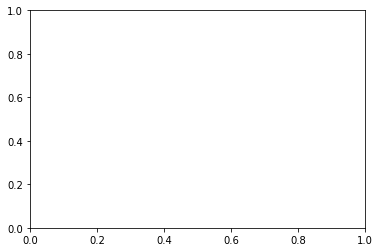

In [40]:
model = Sequential()
model.add(Dense(50, input_dim = Xtrain.shape[1], activation = 'relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam')
meansqerrors={}
for i in range(21):
    j = i/20
    ystrain = ybtrain-j*(ybtrain-yctrain)
    ysvalid = ybvalid-j*(ybvalid-ycvalid)
    model.fit(Xtrain, ystrain, epochs = 500, batch_size = 16)
    score = model.evaluate(Xvalid, ysvalid)
    meansqerrors[j]=score
    print(j,score)
plt.plot(list(meansqerrors.keys()), list(meansqerrors.values()))
    
    
    

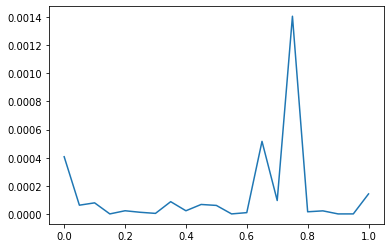

In [42]:
plt.plot(list(meansqerrors.keys()), list(meansqerrors.values()))

# Fit Model to Best Smoothing

In [ ]:
ys = y-j*(y-yc)
ystest = ytest
model = Sequential()
model.add(Dense(50, input_dim = X.shape[1], activation = 'relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['mean_squared_error','mean_absolute_error'])
model.fit(X, y, epochs = 1000, batch_size = 16)

_, MSE, MAE = model.evaluate(Xt, yt)
print('MSE: ' + str(MSE) + ', MAE: '+ str(MAE))

# Predict Bias of Smoothed Test Sets

In [ ]:
test_predicted = model.predict(Xt)
mse = mean_squared_error(yt, test_predicted)
print("Test MSE: ",mse)
mae = mean_absolute_error(yt, test_predicted)
print("Test MAE: ",mae)

# Create Dataset to Visualize Smoothing

In [ ]:
block_data = pd.read_csv("census_block_loc.csv")
block_data = block_data.drop(columns=["BlockCode","County","State"])
block_data["Raw_Bias"]=np.random.normal(scale=10,size=block_data.shape[0])
block_data["County_Bias"]=np.random.normal(scale=1,size=block_data.shape[0])
block_data["Smoothed_Bias"]=np.random.normal(scale=5,size=block_data.shape[0])

# Visualize Smoothing

In [ ]:
#put in visuals here from the dataset "block_data"
#real data will be replaced when Erik figures out the proper way to do the smoothing

import gmaps

locations = sample[['latitude','longitude']]
weights = sample['weight']

coords = (40.75, -74.00)
fig = gmaps.figure(center = coords, zoom_level = 12)
fig.add_layer(gmaps.heatmap_layer(locations, weights=weights))
fig